# ML.py, MLpy, MLPy!
<p style="text-align: center;">MLpy came as a simple question and a project in pespective:
<br><b>"Can I build a discord bot that can tell two pictures apart?"</b></p>
<br>The goal of this Jupyter Notebook is two-fold with one overarching thread:

1. To use a self-made [web scraper](https://github.com/LMquentinLR/derpi_get) that can crawl, if not all, a statistically relevant number of images from [derpibooru](https://derpibooru.org), a linear image database powered by the community revolving around the 'My Little Pony' cartoon.
2. To build a machine learning model capable of telling the difference between 2 types of pictures--to be summarized in a function to implement in my existing Discord bot [BotJack](https://github.com/LMquentinLR/botjack_discord_bot).

### Why image detection for a Discord bot?
<p style="text-align: center;"><b>Discord moderation is hard</b>.</p>

Any Discord moderation team will tell you that. As such, automating as much as possible the <i>mundane stuff</i> is great. A moderation team for instance may want to identify images posted by users on their server. This may have multiple purposes: classification, tagging, games, etc.

<p style="text-align: center;">This notebook will focus on <b>compliance</b>.</p> 

* Servers often have anti-NSFW (i.e. not safe for watch) rules where explicit, grim, and otherwise unwanted content is banned or curtailed to specific server channels.
* Moderation being volunteer-driven on Discord, malicious users may capitalize on idle, asleep, or away-from-keyboard moderators to engage in rule-breaking activities. More commonly, users may simply post a NSFW picture in a SFW-only channel. 
* A bot able to distinguish NSFW content from SFW helps fill in the gaps that may affect any moderation effort. A bot, for instance, could automatically alert moderators whenever a specific content is posted. And in case, it may even start a moderation process prior to any human intervention.

This topic also has an actual application "IRL":
> <b>Automatic content moderation and compliance is a current industry effort among social media companies (e.g. Facebook)</b>

In [1]:
# Importing the necessary modules

import collections
import derpi_get
import datetime
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LeakyReLU
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.layers import GaussianNoise
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import random
from random import shuffle
import shutil

Using TensorFlow backend.


------------------

# Crawling Derpibooru Using the derpi_get module
Using the derpi_get module available [here](https://github.com/LMquentinLR/derpi_get), we download an exhaustive selection of Derpibooru's picture metadata (i.e. all of it).
### Why building a web scraper?
Derpibooru is a website dedicated to MLP fanart. It provides a REST API for rudimentary site functionality, and can be freely used by anyone wanting to produce tools for the site or other webapps that use Derpibooru-provided data.

<b>Derpibooru licensing rules:</b>
"<i>Anyone can use it, users making abusively high numbers of requests may be asked to stop. Your application MUST properly cache, respect server-side cache expiry times. Your client MUST gracefully back off if requests fail (eg non-200 HTTP code), preferably exponentially or fatally.</i>"

A single image can be accessed through the following links:
1. <b>Embedded</b>: [../2072316](https://derpibooru.org/2072316)
2. <b>Default size</b>: [../img/view/2019/6/22/2072316.png](https://derpicdn.net/img/view/2019/6/22/2072316.png) 
3. <b>Small size</b>: [../img/view/2019/6/22/2072316_small.png](https://derpicdn.net/img/view/2019/6/22/2072316_small.png)
4. <b>Medium size</b>: [../img/view/2019/6/22/2072316_medium.png](https://derpicdn.net/img/view/2019/6/22/2072316_medium.png)
5. <b>Large size</b>: [../img/view/2019/6/22/2072316_large.png](https://derpicdn.net/img/view/2019/6/22/2072316_large.png)

The metadata of a single picture can be accessed through the following link:
* https://derpibooru.org/2072316.json

Each picture as the following list of attributes:
>id, created_at, updated_at, first_seen_at, score, comment_count, width, height, file_name, description, uploader, uploader_id, image, upvotes, downvotes, faves, tags, tag_ids, aspect_ratio, original_format, mime_type, sha512_hash, orig_sha512_hash, source_url, representations, is_rendered, is_optimized, interactions, spoilered

In [2]:
#Initializing the scraper object
obj = derpi_get.derpibooru_search()

In [3]:
obj.change_search(instances = "") #switch to instances = "" for a full crawl of derpibooru
obj.crawl()

----|Entering Derpibooru Data Crawler code|----
FILE FOUND: 'derpibooru_metadata.json'
You are requesting the derpibooru page starting with the id 2190529.
You are requesting the derpibooru page starting with the id 2190555.
You are requesting the derpibooru page starting with the id 2190580.
You are requesting the derpibooru page starting with the id 2190605.
You are requesting the derpibooru page starting with the id 2190631.
You are requesting the derpibooru page starting with the id 2190656.
You are requesting the derpibooru page starting with the id 2190681.
You are requesting the derpibooru page starting with the id 2190685.
The crawler scraped the derpibooru metadata. The program will now close.
---------------|Exiting Program|---------------


From time to time, retrieved metadata (as a JSON) would be missing tags value. The following method checks for existing missing tags and retrieve them from derpibooru. It acts as a repair method.

In [4]:
obj.repair()

----|Repairing missing tags in stored JSON|----
----------------|Tags repaired|----------------


## Retrieving IDs based on tag selection

The search function retrieve_ids() of the derpi_get module takes a list of strings that corresponds to picture tags. Each tag must have a prefix, either "<b>+</b>" or "<b>-</b>".

> A "<b>+</b>" prefix indicates that IDs with said tag will be kept

> A "<b>-</b>" prefix indicates that IDs with said tag will be discarded

The object "obj" has a variable called "<b>at_least_one</b>". It is a boolean value so that:
1. if <b>TRUE</b>: Only the IDs which tags <b>contain at least one</b> of the items listed in the variable "<b>tags</b>" with a "+" prefix will be retrieved
2. if <b>FALSE</b>: Only the IDs which tags <b>contain all</b> of the items listed in the variable "<b>tags</b>" with a "+" prefix will be retrieved

## Case Use of derpi_get.retrieve_ids(): Data Exploration Using MatPlotlib

#### What do we want to plot?

> number of pictures pertaining to each five of major ships with one of the main characters of the show.

In [5]:
ship_ids = {"+rarijack":[],"+rarilight":[],"+flarity":[],"+raridash":[],"+raripie":[]}
for ship in ship_ids:
    print(ship)
    obj.change_search(tags = [ship], at_least_one = False)
    ship_ids[ship] = obj.retrieve_ids()
    print("Number of retrieved items: ", len(ship_ids[ship]))
    print("\nFirst item retrieved:")
    print(ship_ids["+rarijack"][0])

+rarijack
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retrieved items:  6113

First item retrieved:
(2190599, 'derpicdn.net/img/2019/11/8/2190599/large.png')
+rarilight
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retrieved items:  1592

First item retrieved:
(2190599, 'derpicdn.net/img/2019/11/8/2190599/large.png')
+flarity
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retrieved items:  1354

First item retrieved:
(2190599, 'derpicdn.net/img/2019/11/8/2190599/large.png')
+raridash
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retrieved items:  1775

First item retrieved:
(2190599, 'derpicdn.net/img/2019/11/8/2190599/large.png')
+raripie
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retri

### MatplotLib

In [6]:
def create_dataframe(name, data):
    """
    Creates the dataframe containing the data for each pairing in ships
    -----
    :param <name>: str ; name of pairing
    :param <data>: lists ; list of tuples containing the pairing data 
    """
    datelist = []
    for entry in data:
        url_split = entry[1].split("/")
        url_split = list(map(int, url_split[-5: -2]))
        datelist.append(datetime.date(url_split[0], url_split[1], url_split[2]))
    shipping_data = pd.DataFrame(data=dict(collections.Counter(datelist)).values(),
                                 index=collections.Counter(datelist))
    shipping_data.sort_index(inplace=True)
    shipping_data.index = pd.to_datetime(shipping_data.index)
    shipping_data = shipping_data.reindex(pd.date_range(shipping_data.index[0],shipping_data.index[-1]), 
                                          fill_value=0)
    shipping_data[1] = shipping_data.cumsum()
    shipping_data.columns = [name, "Cumulative Sum"]
    return shipping_data

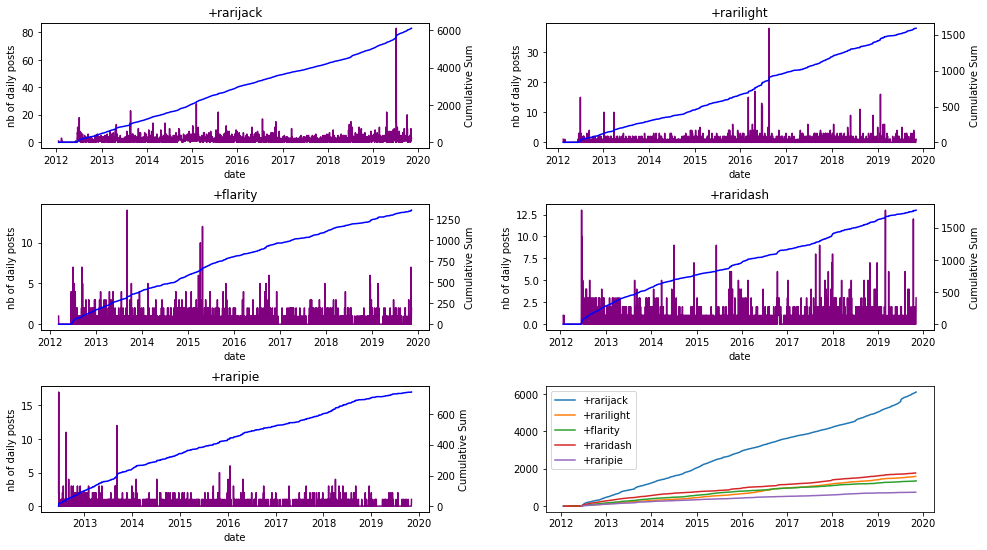

In [7]:
years = mdates.YearLocator() #every year
yearsFmt = mdates.DateFormatter("%Y")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 9))
fig.subplots_adjust(hspace=.45, wspace=.3)

counter = 0
for i in range(3):
    for j in range(2):
        if i * j != 2:
            df = create_dataframe(list(ship_ids.keys())[counter], ship_ids[list(ship_ids.keys())[counter]])
            axes[i, j].set_title(list(ship_ids.keys())[counter])
            axes[i, j].plot(df.index, 
                            df[list(ship_ids.keys())[counter]].values, 
                            color="purple", 
                            label=list(ship_ids.keys())[counter])
            ax2 = axes[i, j].twinx()
            ax2.plot(df.index, 
                     df["Cumulative Sum"].values, 
                     color="blue")
            ax2.set_ylabel("Cumulative Sum")
            axes[i, j].set_xlabel("date")
            axes[i, j].set_ylabel("nb of daily posts")
            axes[i, j].xaxis.set_major_locator(years)
            axes[i, j].xaxis.set_major_formatter(yearsFmt)
            axes[2, 1].plot(df.index, df["Cumulative Sum"].values,
                            label=list(ship_ids.keys())[counter])
        counter += 1

axes[2, 1].xaxis.set_major_locator(years)
axes[2, 1].xaxis.set_major_formatter(yearsFmt)
axes[2, 1].legend()
plt.savefig('shipping_chart.png')

# SEPARATING SFW FROM NSFW PICTURES

## Downloading pictures

We need to download a set of pictures which can be used to fit a machine learning model.

In [8]:
def download(tag_lists, nb_of_requests):
    """
    Downloads pictures based on a list of tag.
    ---
    :param <tags>: list ; list of tags to sort and download pictures
    :param <nb_of_requests>: int ; number of download requests to perform
    """
    obj = derpi_get.derpibooru_search()
    for tags in tag_lists:
        obj.change_search(tags = tags, at_least_one = True)
        id_list = obj.retrieve_ids()
        obj.request_imgs(tags, id_list, nb_of_requests)

In [9]:
tags = [["+safe","-comic", "-meme", "-text"], 
        ["+explicit", "+grimdark", "+suggestive", "+questionable", "-comic", "-meme", "-text"]]

In [10]:
download(tags, 11000)

----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
------|Requesting images from derpibooru|-----
1 11000
The picture 625282 was downloaded.
2 11000
The picture 325823 was downloaded.
3 11000
The picture 313154 was downloaded.
4 11000
The picture 986916 was downloaded.
5 11000
The picture 673007 was downloaded.
6 11000
The picture 2101870 was downloaded.
7 11000
The picture 1480251 was downloaded.
8 11000
The picture 1970065 was downloaded.
9 11000
The picture 1984031 was downloaded.
10 11000
The picture 1051367 was downloaded.
11 11000
The picture 796560 was downloaded.
12 11000
The picture 786815 was downloaded.
13 11000
The picture 644823 was downloaded.
14 11000
The picture 197912 was downloaded.
15 11000
The picture 1386350 was downloaded.
16 11000
The picture 1786155 was downloaded.
17 11000
The picture 768232 was downloaded.
18 11000
The picture 2123223 was downloaded.
19 11000
The picture 901434 was downloaded.
20 11000
The picture 1

The picture 143299 was downloaded.
189 11009
The picture 774438 was downloaded.
190 11009
The picture 458996 was downloaded.
191 11009
The picture 1579717 was downloaded.
192 11009
The picture 651545 was downloaded.
193 11009
The picture 992663 was downloaded.
194 11009
The picture 140198 was downloaded.
195 11009
The picture 1852814 was downloaded.
196 11009
The picture 1802717 was downloaded.
197 11009
The picture 190732 was downloaded.
198 11009
The picture 1458733 was downloaded.
199 11009
The picture 1186344 was downloaded.
200 11009
The picture 1103891 was downloaded.
201 11009
The picture 1752705 was downloaded.
202 11009
The picture 876369 was downloaded.
203 11009
The picture 2106358 was downloaded.
204 11009
The picture 485894 was downloaded.
205 11009
The picture 1840605 was downloaded.
206 11009
The picture 1690453 was downloaded.
207 11009
The picture 436210 was downloaded.
208 11009
The picture 1709115 was downloaded.
209 11009
The picture 1437028 was downloaded.
210 1100

The picture 2057613 was downloaded.
374 11015
The picture 633759 was downloaded.
375 11015
The picture 1819130 was downloaded.
376 11015
The picture 916562 was downloaded.
377 11015
The picture 605922 was downloaded.
378 11015
379 11016
The picture 1851735 was downloaded.
380 11016
The picture 1138882 was downloaded.
381 11016
The picture 1820606 was downloaded.
382 11016
The picture 1336610 was downloaded.
383 11016
The picture 678846 was downloaded.
384 11016
The picture 477514 was downloaded.
385 11016
The picture 459506 was downloaded.
386 11016
The picture 794464 was downloaded.
387 11016
The picture 1584035 was downloaded.
388 11016
The picture 1230462 was downloaded.
389 11016
The picture 1440518 was downloaded.
390 11016
The picture 37457 was downloaded.
391 11016
The picture 1840183 was downloaded.
392 11016
The picture 1129029 was downloaded.
393 11016
The picture 241577 was downloaded.
394 11016
The picture 728155 was downloaded.
395 11016
396 11017
The picture 327332 was do

The picture 1767444 was downloaded.
560 11022
The picture 2010661 was downloaded.
561 11022
The picture 1595361 was downloaded.
562 11022
The picture 2182761 was downloaded.
563 11022
The picture 1787842 was downloaded.
564 11022
The picture 943589 was downloaded.
565 11022
The picture 1079694 was downloaded.
566 11022
The picture 1144915 was downloaded.
567 11022
The picture 2065639 was downloaded.
568 11022
The picture 1241184 was downloaded.
569 11022
The picture 59737 was downloaded.
570 11022
The picture 1804379 was downloaded.
571 11022
The picture 1578753 was downloaded.
572 11022
The picture 1251265 was downloaded.
573 11022
The picture 1079969 was downloaded.
574 11022
The picture 1192568 was downloaded.
575 11022
The picture 2028872 was downloaded.
576 11022
The picture 1014679 was downloaded.
577 11022
The picture 462704 was downloaded.
578 11022
579 11023
The picture 1807328 was downloaded.
580 11023
The picture 494486 was downloaded.
581 11023
582 11024
The picture 144424 

The picture 1630559 was downloaded.
749 11033
The picture 1795114 was downloaded.
750 11033
The picture 688394 was downloaded.
751 11033
The picture 235458 was downloaded.
752 11033
The picture 968126 was downloaded.
753 11033
The picture 1966947 was downloaded.
754 11033
755 11034
The picture 416409 was downloaded.
756 11034
The picture 1920705 was downloaded.
757 11034
The picture 2032694 was downloaded.
758 11034
The picture 1887416 was downloaded.
759 11034
The picture 452462 was downloaded.
760 11034
The picture 619887 was downloaded.
761 11034
The picture 920341 was downloaded.
762 11034
The picture 781055 was downloaded.
763 11034
The picture 73135 was downloaded.
764 11034
The picture 1969385 was downloaded.
765 11034
The picture 1246683 was downloaded.
766 11034
The picture 1231387 was downloaded.
767 11034
The picture 1684441 was downloaded.
768 11034
The picture 259967 was downloaded.
769 11034
The picture 1569394 was downloaded.
770 11034
The picture 914232 was downloaded.


The picture 2002630 was downloaded.
935 11040
The picture 949948 was downloaded.
936 11040
The picture 487581 was downloaded.
937 11040
The picture 1431080 was downloaded.
938 11040
The picture 1271264 was downloaded.
939 11040
The picture 1626675 was downloaded.
940 11040
The picture 1302415 was downloaded.
941 11040
The picture 1059747 was downloaded.
942 11040
The picture 1542476 was downloaded.
943 11040
The picture 1775852 was downloaded.
944 11040
The picture 597928 was downloaded.
945 11040
The picture 461523 was downloaded.
946 11040
The picture 1943570 was downloaded.
947 11040
The picture 800056 was downloaded.
948 11040
The picture 942975 was downloaded.
949 11040
The picture 1289663 was downloaded.
950 11040
The picture 313588 was downloaded.
951 11040
The picture 808897 was downloaded.
952 11040
The picture 1758216 was downloaded.
953 11040
The picture 1885933 was downloaded.
954 11040
The picture 747514 was downloaded.
955 11040
The picture 1410205 was downloaded.
956 110

The picture 2116030 was downloaded.
1117 11045
The picture 852214 was downloaded.
1118 11045
The picture 31417 was downloaded.
1119 11045
The picture 1474471 was downloaded.
1120 11045
The picture 1151013 was downloaded.
1121 11045
The picture 304915 was downloaded.
1122 11045
The picture 1725692 was downloaded.
1123 11045
The picture 659920 was downloaded.
1124 11045
The picture 1328098 was downloaded.
1125 11045
The picture 1867772 was downloaded.
1126 11045
The picture 1394449 was downloaded.
1127 11045
The picture 1190854 was downloaded.
1128 11045
The picture 1117141 was downloaded.
1129 11045
The picture 257356 was downloaded.
1130 11045
The picture 1532143 was downloaded.
1131 11045
The picture 737574 was downloaded.
1132 11045
The picture 93896 was downloaded.
1133 11045
The picture 1965522 was downloaded.
1134 11045
The picture 1110221 was downloaded.
1135 11045
The picture 1146494 was downloaded.
1136 11045
The picture 382240 was downloaded.
1137 11045
The picture 1452934 was

The picture 1128236 was downloaded.
1302 11056
The picture 706676 was downloaded.
1303 11056
The picture 567145 was downloaded.
1304 11056
The picture 719195 was downloaded.
1305 11056
The picture 1923039 was downloaded.
1306 11056
The picture 1321351 was downloaded.
1307 11056
The picture 2028493 was downloaded.
1308 11056
The picture 1518002 was downloaded.
1309 11056
The picture 1721979 was downloaded.
1310 11056
The picture 1739736 was downloaded.
1311 11056
The picture 1257169 was downloaded.
1312 11056
The picture 1871414 was downloaded.
1313 11056
The picture 102608 was downloaded.
1314 11056
The picture 419050 was downloaded.
1315 11056
The picture 2045367 was downloaded.
1316 11056
The picture 1254258 was downloaded.
1317 11056
The picture 253557 was downloaded.
1318 11056
The picture 598152 was downloaded.
1319 11056
The picture 2042933 was downloaded.
1320 11056
The picture 722051 was downloaded.
1321 11056
The picture 213087 was downloaded.
1322 11056
The picture 406749 was

The picture 820998 was downloaded.
1483 11061
The picture 68251 was downloaded.
1484 11061
The picture 944235 was downloaded.
1485 11061
The picture 1619454 was downloaded.
1486 11061
The picture 1798058 was downloaded.
1487 11061
The picture 354685 was downloaded.
1488 11061
The picture 1679064 was downloaded.
1489 11061
The picture 1679781 was downloaded.
1490 11061
The picture 2054110 was downloaded.
1491 11061
1492 11062
The picture 190579 was downloaded.
1493 11062
The picture 376681 was downloaded.
1494 11062
The picture 609212 was downloaded.
1495 11062
The picture 790422 was downloaded.
1496 11062
The picture 58437 was downloaded.
1497 11062
The picture 1360136 was downloaded.
1498 11062
The picture 1334365 was downloaded.
1499 11062
The picture 2142204 was downloaded.
1500 11062
The picture 123848 was downloaded.
1501 11062
The picture 85223 was downloaded.
1502 11062
The picture 1823616 was downloaded.
1503 11062
The picture 2100519 was downloaded.
1504 11062
The picture 2009

The picture 243996 was downloaded.
1667 11070
The picture 987940 was downloaded.
1668 11070
The picture 1277599 was downloaded.
1669 11070
The picture 2063413 was downloaded.
1670 11070
The picture 66809 was downloaded.
1671 11070
The picture 455631 was downloaded.
1672 11070
The picture 1745265 was downloaded.
1673 11070
The picture 942703 was downloaded.
1674 11070
The picture 492706 was downloaded.
1675 11070
The picture 568842 was downloaded.
1676 11070
The picture 449191 was downloaded.
1677 11070
The picture 2143401 was downloaded.
1678 11070
The picture 1121092 was downloaded.
1679 11070
The picture 1247394 was downloaded.
1680 11070
The picture 1161186 was downloaded.
1681 11070
The picture 2168130 was downloaded.
1682 11070
The picture 1142145 was downloaded.
1683 11070
The picture 1423199 was downloaded.
1684 11070
The picture 1714757 was downloaded.
1685 11070
The picture 1368338 was downloaded.
1686 11070
The picture 1955718 was downloaded.
1687 11070
The picture 1535557 wa

The picture 173430 was downloaded.
1852 11081
The picture 1873756 was downloaded.
1853 11081
The picture 915531 was downloaded.
1854 11081
The picture 1775112 was downloaded.
1855 11081
The picture 2136475 was downloaded.
1856 11081
The picture 2113708 was downloaded.
1857 11081
The picture 1539456 was downloaded.
1858 11081
The picture 1347640 was downloaded.
1859 11081
The picture 2180159 was downloaded.
1860 11081
The picture 463030 was downloaded.
1861 11081
The picture 668316 was downloaded.
1862 11081
The picture 469716 was downloaded.
1863 11081
The picture 557742 was downloaded.
1864 11081
The picture 735532 was downloaded.
1865 11081
The picture 615107 was downloaded.
1866 11081
The picture 1459556 was downloaded.
1867 11081
The picture 326585 was downloaded.
1868 11081
The picture 1234025 was downloaded.
1869 11081
The picture 1517969 was downloaded.
1870 11081
The picture 341482 was downloaded.
1871 11081
The picture 1008638 was downloaded.
1872 11081
The picture 477046 was 

The picture 407908 was downloaded.
2034 11088
The picture 384871 was downloaded.
2035 11088
The picture 92429 was downloaded.
2036 11088
The picture 1280756 was downloaded.
2037 11088
The picture 118854 was downloaded.
2038 11088
The picture 945388 was downloaded.
2039 11088
The picture 46621 was downloaded.
2040 11088
The picture 1332161 was downloaded.
2041 11088
The picture 2156369 was downloaded.
2042 11088
The picture 1431180 was downloaded.
2043 11088
The picture 1387977 was downloaded.
2044 11088
2045 11089
The picture 1106033 was downloaded.
2046 11089
The picture 1792504 was downloaded.
2047 11089
The picture 237332 was downloaded.
2048 11089
2049 11090
The picture 1150889 was downloaded.
2050 11090
The picture 1570771 was downloaded.
2051 11090
The picture 659924 was downloaded.
2052 11090
The picture 1010320 was downloaded.
2053 11090
The picture 2131998 was downloaded.
2054 11090
The picture 815124 was downloaded.
2055 11090
The picture 1188930 was downloaded.
2056 11090
Th

The picture 1843797 was downloaded.
2216 11094
The picture 888449 was downloaded.
2217 11094
The picture 407372 was downloaded.
2218 11094
The picture 1313757 was downloaded.
2219 11094
The picture 1551921 was downloaded.
2220 11094
The picture 2009125 was downloaded.
2221 11094
The picture 1106497 was downloaded.
2222 11094
The picture 1241096 was downloaded.
2223 11094
The picture 2172819 was downloaded.
2224 11094
The picture 1029226 was downloaded.
2225 11094
The picture 1199568 was downloaded.
2226 11094
The picture 993665 was downloaded.
2227 11094
The picture 1445977 was downloaded.
2228 11094
The picture 1380258 was downloaded.
2229 11094
The picture 966055 was downloaded.
2230 11094
The picture 171412 was downloaded.
2231 11094
The picture 1149168 was downloaded.
2232 11094
The picture 328061 was downloaded.
2233 11094
The picture 118342 was downloaded.
2234 11094
The picture 734326 was downloaded.
2235 11094
The picture 1042687 was downloaded.
2236 11094
The picture 2160046 w

The picture 484236 was downloaded.
2401 11105
The picture 1434444 was downloaded.
2402 11105
The picture 335465 was downloaded.
2403 11105
The picture 1910202 was downloaded.
2404 11105
The picture 2151473 was downloaded.
2405 11105
The picture 550332 was downloaded.
2406 11105
The picture 1757043 was downloaded.
2407 11105
2408 11106
The picture 1384587 was downloaded.
2409 11106
The picture 1377829 was downloaded.
2410 11106
The picture 743087 was downloaded.
2411 11106
The picture 1479001 was downloaded.
2412 11106
The picture 36886 was downloaded.
2413 11106
The picture 428339 was downloaded.
2414 11106
The picture 1207746 was downloaded.
2415 11106
The picture 1112848 was downloaded.
2416 11106
The picture 128640 was downloaded.
2417 11106
The picture 1115059 was downloaded.
2418 11106
The picture 1169977 was downloaded.
2419 11106
The picture 1492317 was downloaded.
2420 11106
The picture 224319 was downloaded.
2421 11106
The picture 424394 was downloaded.
2422 11106
The picture 

The picture 276672 was downloaded.
2583 11112
The picture 1375617 was downloaded.
2584 11112
The picture 262798 was downloaded.
2585 11112
The picture 2054247 was downloaded.
2586 11112
The picture 647632 was downloaded.
2587 11112
The picture 171155 was downloaded.
2588 11112
The picture 1951149 was downloaded.
2589 11112
The picture 474204 was downloaded.
2590 11112
The picture 1689950 was downloaded.
2591 11112
The picture 120747 was downloaded.
2592 11112
The picture 1184582 was downloaded.
2593 11112
The picture 1613969 was downloaded.
2594 11112
The picture 1936247 was downloaded.
2595 11112
The picture 469337 was downloaded.
2596 11112
The picture 1248464 was downloaded.
2597 11112
The picture 831861 was downloaded.
2598 11112
The picture 1717487 was downloaded.
2599 11112
The picture 552527 was downloaded.
2600 11112
The picture 768862 was downloaded.
2601 11112
The picture 2180454 was downloaded.
2602 11112
The picture 1246244 was downloaded.
2603 11112
The picture 62903 was d

The picture 1920652 was downloaded.
2766 11120
The picture 363009 was downloaded.
2767 11120
The picture 438011 was downloaded.
2768 11120
The picture 1411326 was downloaded.
2769 11120
The picture 33439 was downloaded.
2770 11120
The picture 397685 was downloaded.
2771 11120
The picture 1762547 was downloaded.
2772 11120
The picture 505938 was downloaded.
2773 11120
The picture 2059179 was downloaded.
2774 11120
The picture 1999937 was downloaded.
2775 11120
The picture 1709778 was downloaded.
2776 11120
The picture 1696131 was downloaded.
2777 11120
The picture 1665395 was downloaded.
2778 11120
The picture 1437811 was downloaded.
2779 11120
The picture 108792 was downloaded.
2780 11120
The picture 1813314 was downloaded.
2781 11120
The picture 1709830 was downloaded.
2782 11120
The picture 365300 was downloaded.
2783 11120
The picture 1658064 was downloaded.
2784 11120
The picture 447928 was downloaded.
2785 11120
The picture 1058195 was downloaded.
2786 11120
The picture 109514 was

The picture 1617479 was downloaded.
2950 11130
2951 11131
The picture 1316620 was downloaded.
2952 11131
The picture 64443 was downloaded.
2953 11131
The picture 726456 was downloaded.
2954 11131
The picture 1431061 was downloaded.
2955 11131
2956 11132
The picture 637377 was downloaded.
2957 11132
The picture 1518820 was downloaded.
2958 11132
The picture 1294005 was downloaded.
2959 11132
The picture 822837 was downloaded.
2960 11132
The picture 951198 was downloaded.
2961 11132
The picture 1819462 was downloaded.
2962 11132
The picture 2009728 was downloaded.
2963 11132
The picture 1401801 was downloaded.
2964 11132
The picture 309254 was downloaded.
2965 11132
The picture 829596 was downloaded.
2966 11132
The picture 1620592 was downloaded.
2967 11132
The picture 798469 was downloaded.
2968 11132
The picture 102199 was downloaded.
2969 11132
The picture 3037 was downloaded.
2970 11132
The picture 1547693 was downloaded.
2971 11132
The picture 1497788 was downloaded.
2972 11132
The 

The picture 1348305 was downloaded.
3130 11135
The picture 256968 was downloaded.
3131 11135
The picture 474017 was downloaded.
3132 11135
The picture 768724 was downloaded.
3133 11135
The picture 1368674 was downloaded.
3134 11135
The picture 264131 was downloaded.
3135 11135
The picture 451272 was downloaded.
3136 11135
The picture 166507 was downloaded.
3137 11135
The picture 1708937 was downloaded.
3138 11135
The picture 645122 was downloaded.
3139 11135
The picture 157092 was downloaded.
3140 11135
The picture 172930 was downloaded.
3141 11135
3142 11136
The picture 1958258 was downloaded.
3143 11136
The picture 885766 was downloaded.
3144 11136
The picture 1609019 was downloaded.
3145 11136
The picture 538384 was downloaded.
3146 11136
The picture 181285 was downloaded.
3147 11136
The picture 679837 was downloaded.
3148 11136
The picture 1095070 was downloaded.
3149 11136
The picture 1976055 was downloaded.
3150 11136
The picture 57377 was downloaded.
3151 11136
The picture 37770

The picture 1023780 was downloaded.
3316 11147
The picture 1075701 was downloaded.
3317 11147
The picture 467394 was downloaded.
3318 11147
The picture 1174955 was downloaded.
3319 11147
The picture 1574297 was downloaded.
3320 11147
The picture 1020426 was downloaded.
3321 11147
The picture 2005997 was downloaded.
3322 11147
The picture 1086676 was downloaded.
3323 11147
The picture 1093692 was downloaded.
3324 11147
The picture 1503075 was downloaded.
3325 11147
The picture 1874226 was downloaded.
3326 11147
The picture 1377390 was downloaded.
3327 11147
The picture 1227745 was downloaded.
3328 11147
The picture 1820631 was downloaded.
3329 11147
The picture 188752 was downloaded.
3330 11147
The picture 1549007 was downloaded.
3331 11147
The picture 1227850 was downloaded.
3332 11147
The picture 907875 was downloaded.
3333 11147
The picture 346419 was downloaded.
3334 11147
The picture 1261794 was downloaded.
3335 11147
The picture 1931493 was downloaded.
3336 11147
The picture 13131

The picture 315017 was downloaded.
3498 11154
The picture 164009 was downloaded.
3499 11154
The picture 1870354 was downloaded.
3500 11154
The picture 1073448 was downloaded.
3501 11154
The picture 1327172 was downloaded.
3502 11154
The picture 1977516 was downloaded.
3503 11154
The picture 1055585 was downloaded.
3504 11154
The picture 1422233 was downloaded.
3505 11154
The picture 1678030 was downloaded.
3506 11154
The picture 1301359 was downloaded.
3507 11154
The picture 245139 was downloaded.
3508 11154
The picture 800891 was downloaded.
3509 11154
The picture 1777729 was downloaded.
3510 11154
The picture 1198643 was downloaded.
3511 11154
The picture 735771 was downloaded.
3512 11154
The picture 144682 was downloaded.
3513 11154
3514 11155
The picture 1130274 was downloaded.
3515 11155
The picture 651547 was downloaded.
3516 11155
The picture 1654422 was downloaded.
3517 11155
The picture 1926941 was downloaded.
3518 11155
The picture 353890 was downloaded.
3519 11155
The pictur

The picture 1696272 was downloaded.
3679 11160
3680 11161
The picture 1289299 was downloaded.
3681 11161
The picture 509380 was downloaded.
3682 11161
The picture 644871 was downloaded.
3683 11161
The picture 1577933 was downloaded.
3684 11161
The picture 1047266 was downloaded.
3685 11161
The picture 1755324 was downloaded.
3686 11161
The picture 571958 was downloaded.
3687 11161
The picture 1572619 was downloaded.
3688 11161
The picture 1118593 was downloaded.
3689 11161
The picture 1898835 was downloaded.
3690 11161
The picture 1313473 was downloaded.
3691 11161
The picture 1579644 was downloaded.
3692 11161
The picture 1037970 was downloaded.
3693 11161
The picture 255989 was downloaded.
3694 11161
The picture 1502667 was downloaded.
3695 11161
The picture 1839529 was downloaded.
3696 11161
The picture 1932528 was downloaded.
3697 11161
The picture 529015 was downloaded.
3698 11161
The picture 1054116 was downloaded.
3699 11161
The picture 2109620 was downloaded.
3700 11161
The pic

The picture 60436 was downloaded.
3862 11169
3863 11170
The picture 1212179 was downloaded.
3864 11170
The picture 485800 was downloaded.
3865 11170
The picture 991800 was downloaded.
3866 11170
The picture 1511781 was downloaded.
3867 11170
The picture 1693346 was downloaded.
3868 11170
The picture 1458556 was downloaded.
3869 11170
3870 11171
The picture 1714701 was downloaded.
3871 11171
3872 11172
The picture 2044774 was downloaded.
3873 11172
The picture 113855 was downloaded.
3874 11172
The picture 1108038 was downloaded.
3875 11172
The picture 245318 was downloaded.
3876 11172
The picture 1961277 was downloaded.
3877 11172
The picture 1369972 was downloaded.
3878 11172
The picture 2123415 was downloaded.
3879 11172
The picture 2091312 was downloaded.
3880 11172
The picture 374738 was downloaded.
3881 11172
3882 11173
3883 11174
The picture 1339414 was downloaded.
3884 11174
The picture 1112959 was downloaded.
3885 11174
The picture 328198 was downloaded.
3886 11174
The picture 1

The picture 171718 was downloaded.
4047 11180
The picture 600773 was downloaded.
4048 11180
The picture 2013180 was downloaded.
4049 11180
The picture 1574404 was downloaded.
4050 11180
The picture 1274640 was downloaded.
4051 11180
The picture 1396552 was downloaded.
4052 11180
The picture 2113748 was downloaded.
4053 11180
The picture 1540046 was downloaded.
4054 11180
The picture 248159 was downloaded.
4055 11180
The picture 2061169 was downloaded.
4056 11180
The picture 2172859 was downloaded.
4057 11180
The picture 1182203 was downloaded.
4058 11180
The picture 2170891 was downloaded.
4059 11180
The picture 967876 was downloaded.
4060 11180
The picture 1469192 was downloaded.
4061 11180
The picture 1875721 was downloaded.
4062 11180
The picture 2124448 was downloaded.
4063 11180
The picture 1287516 was downloaded.
4064 11180
The picture 104317 was downloaded.
4065 11180
The picture 1610587 was downloaded.
4066 11180
The picture 2026829 was downloaded.
4067 11180
The picture 163681

The picture 1135870 was downloaded.
4230 11189
The picture 73818 was downloaded.
4231 11189
The picture 586432 was downloaded.
4232 11189
The picture 62306 was downloaded.
4233 11189
The picture 1842577 was downloaded.
4234 11189
The picture 2049383 was downloaded.
4235 11189
The picture 1605373 was downloaded.
4236 11189
The picture 843619 was downloaded.
4237 11189
The picture 1949841 was downloaded.
4238 11189
The picture 1912443 was downloaded.
4239 11189
The picture 1162540 was downloaded.
4240 11189
The picture 1516617 was downloaded.
4241 11189
The picture 374532 was downloaded.
4242 11189
The picture 972013 was downloaded.
4243 11189
The picture 1712880 was downloaded.
4244 11189
4245 11190
The picture 310245 was downloaded.
4246 11190
The picture 1662187 was downloaded.
4247 11190
The picture 886910 was downloaded.
4248 11190
The picture 1657973 was downloaded.
4249 11190
The picture 1107576 was downloaded.
4250 11190
4251 11191
The picture 1857571 was downloaded.
4252 11191
T

The picture 921845 was downloaded.
4411 11194
The picture 285904 was downloaded.
4412 11194
The picture 1208397 was downloaded.
4413 11194
The picture 962739 was downloaded.
4414 11194
The picture 1289169 was downloaded.
4415 11194
The picture 594445 was downloaded.
4416 11194
The picture 1370964 was downloaded.
4417 11194
The picture 1807541 was downloaded.
4418 11194
The picture 1383756 was downloaded.
4419 11194
The picture 144730 was downloaded.
4420 11194
The picture 1656076 was downloaded.
4421 11194
The picture 604407 was downloaded.
4422 11194
The picture 2180651 was downloaded.
4423 11194
The picture 301664 was downloaded.
4424 11194
The picture 164150 was downloaded.
4425 11194
The picture 1561932 was downloaded.
4426 11194
The picture 67857 was downloaded.
4427 11194
The picture 1727604 was downloaded.
4428 11194
The picture 2032443 was downloaded.
4429 11194
The picture 1604197 was downloaded.
4430 11194
4431 11195
The picture 1773336 was downloaded.
4432 11195
4433 11196
T

The picture 1790977 was downloaded.
4595 11204
The picture 362609 was downloaded.
4596 11204
The picture 457908 was downloaded.
4597 11204
The picture 2121061 was downloaded.
4598 11204
The picture 1389642 was downloaded.
4599 11204
The picture 1175543 was downloaded.
4600 11204
The picture 367866 was downloaded.
4601 11204
The picture 410740 was downloaded.
4602 11204
The picture 532719 was downloaded.
4603 11204
The picture 97230 was downloaded.
4604 11204
4605 11205
The picture 50934 was downloaded.
4606 11205
The picture 1338376 was downloaded.
4607 11205
The picture 2036579 was downloaded.
4608 11205
The picture 397484 was downloaded.
4609 11205
The picture 1300013 was downloaded.
4610 11205
The picture 3911 was downloaded.
4611 11205
4612 11206
The picture 753487 was downloaded.
4613 11206
The picture 2020859 was downloaded.
4614 11206
The picture 53788 was downloaded.
4615 11206
The picture 2006741 was downloaded.
4616 11206
The picture 572663 was downloaded.
4617 11206
The pict

The picture 856676 was downloaded.
4778 11212
The picture 1729175 was downloaded.
4779 11212
The picture 1858366 was downloaded.
4780 11212
The picture 953630 was downloaded.
4781 11212
The picture 148860 was downloaded.
4782 11212
The picture 2054283 was downloaded.
4783 11212
The picture 557218 was downloaded.
4784 11212
The picture 2120166 was downloaded.
4785 11212
The picture 1179644 was downloaded.
4786 11212
The picture 1521108 was downloaded.
4787 11212
The picture 150063 was downloaded.
4788 11212
The picture 397814 was downloaded.
4789 11212
The picture 1340734 was downloaded.
4790 11212
The picture 1462650 was downloaded.
4791 11212
The picture 1665328 was downloaded.
4792 11212
The picture 319837 was downloaded.
4793 11212
The picture 1383582 was downloaded.
4794 11212
The picture 756053 was downloaded.
4795 11212
The picture 1908102 was downloaded.
4796 11212
The picture 1055370 was downloaded.
4797 11212
The picture 303813 was downloaded.
4798 11212
The picture 1640026 wa

The picture 608684 was downloaded.
4959 11218
4960 11219
The picture 1064627 was downloaded.
4961 11219
The picture 861663 was downloaded.
4962 11219
The picture 1407430 was downloaded.
4963 11219
The picture 672421 was downloaded.
4964 11219
The picture 449261 was downloaded.
4965 11219
The picture 272267 was downloaded.
4966 11219
The picture 566688 was downloaded.
4967 11219
The picture 1231105 was downloaded.
4968 11219
The picture 2117640 was downloaded.
4969 11219
The picture 1123848 was downloaded.
4970 11219
The picture 1894798 was downloaded.
4971 11219
The picture 1316412 was downloaded.
4972 11219
The picture 1075744 was downloaded.
4973 11219
The picture 1461460 was downloaded.
4974 11219
The picture 1006955 was downloaded.
4975 11219
The picture 246561 was downloaded.
4976 11219
The picture 948737 was downloaded.
4977 11219
The picture 138670 was downloaded.
4978 11219
The picture 91075 was downloaded.
4979 11219
The picture 739063 was downloaded.
4980 11219
The picture 20

The picture 2035071 was downloaded.
5143 11228
5144 11229
The picture 1403979 was downloaded.
5145 11229
The picture 955450 was downloaded.
5146 11229
The picture 1350818 was downloaded.
5147 11229
The picture 657132 was downloaded.
5148 11229
The picture 294310 was downloaded.
5149 11229
5150 11230
The picture 1207575 was downloaded.
5151 11230
The picture 1311838 was downloaded.
5152 11230
The picture 2111223 was downloaded.
5153 11230
The picture 1045889 was downloaded.
5154 11230
The picture 36427 was downloaded.
5155 11230
The picture 1139002 was downloaded.
5156 11230
The picture 1019422 was downloaded.
5157 11230
The picture 1690631 was downloaded.
5158 11230
The picture 1279070 was downloaded.
5159 11230
The picture 686885 was downloaded.
5160 11230
The picture 1677812 was downloaded.
5161 11230
The picture 2023442 was downloaded.
5162 11230
The picture 1379680 was downloaded.
5163 11230
The picture 2097299 was downloaded.
5164 11230
The picture 1682136 was downloaded.
5165 112

The picture 1522606 was downloaded.
5326 11237
5327 11238
The picture 768696 was downloaded.
5328 11238
The picture 1987878 was downloaded.
5329 11238
The picture 1994036 was downloaded.
5330 11238
The picture 1833829 was downloaded.
5331 11238
The picture 1497129 was downloaded.
5332 11238
The picture 1379802 was downloaded.
5333 11238
The picture 553490 was downloaded.
5334 11238
The picture 2114886 was downloaded.
5335 11238
The picture 1451552 was downloaded.
5336 11238
The picture 1009204 was downloaded.
5337 11238
The picture 2102108 was downloaded.
5338 11238
The picture 2049439 was downloaded.
5339 11238
The picture 2175816 was downloaded.
5340 11238
The picture 1842860 was downloaded.
5341 11238
The picture 369353 was downloaded.
5342 11238
The picture 402929 was downloaded.
5343 11238
The picture 2074934 was downloaded.
5344 11238
The picture 245702 was downloaded.
5345 11238
The picture 66845 was downloaded.
5346 11238
The picture 1860720 was downloaded.
5347 11238
The pictu

The picture 1267696 was downloaded.
5507 11242
The picture 1893632 was downloaded.
5508 11242
The picture 1946634 was downloaded.
5509 11242
The picture 1927874 was downloaded.
5510 11242
The picture 213348 was downloaded.
5511 11242
The picture 696977 was downloaded.
5512 11242
The picture 421770 was downloaded.
5513 11242
The picture 2099728 was downloaded.
5514 11242
The picture 2150686 was downloaded.
5515 11242
The picture 487412 was downloaded.
5516 11242
The picture 531449 was downloaded.
5517 11242
The picture 1162382 was downloaded.
5518 11242
The picture 2184605 was downloaded.
5519 11242
The picture 655368 was downloaded.
5520 11242
The picture 1823467 was downloaded.
5521 11242
The picture 1498437 was downloaded.
5522 11242
The picture 48238 was downloaded.
5523 11242
The picture 622281 was downloaded.
5524 11242
The picture 538994 was downloaded.
5525 11242
The picture 312982 was downloaded.
5526 11242
The picture 888428 was downloaded.
5527 11242
The picture 1472044 was d

The picture 1563451 was downloaded.
5687 11246
The picture 1071899 was downloaded.
5688 11246
The picture 312463 was downloaded.
5689 11246
The picture 642319 was downloaded.
5690 11246
The picture 85797 was downloaded.
5691 11246
The picture 1219431 was downloaded.
5692 11246
The picture 1687867 was downloaded.
5693 11246
The picture 991019 was downloaded.
5694 11246
The picture 1316515 was downloaded.
5695 11246
The picture 1965372 was downloaded.
5696 11246
The picture 250509 was downloaded.
5697 11246
5698 11247
The picture 1208428 was downloaded.
5699 11247
The picture 2089277 was downloaded.
5700 11247
The picture 2027388 was downloaded.
5701 11247
The picture 1843038 was downloaded.
5702 11247
The picture 1818451 was downloaded.
5703 11247
The picture 1223552 was downloaded.
5704 11247
The picture 1756466 was downloaded.
5705 11247
The picture 190105 was downloaded.
5706 11247
The picture 1340844 was downloaded.
5707 11247
The picture 210019 was downloaded.
5708 11247
The pictur

The picture 735168 was downloaded.
5873 11258
The picture 245598 was downloaded.
5874 11258
The picture 642763 was downloaded.
5875 11258
The picture 2121766 was downloaded.
5876 11258
The picture 818231 was downloaded.
5877 11258
The picture 1245935 was downloaded.
5878 11258
The picture 2029796 was downloaded.
5879 11258
The picture 1488587 was downloaded.
5880 11258
The picture 121562 was downloaded.
5881 11258
The picture 954160 was downloaded.
5882 11258
The picture 29447 was downloaded.
5883 11258
The picture 947627 was downloaded.
5884 11258
The picture 2078267 was downloaded.
5885 11258
The picture 1838761 was downloaded.
5886 11258
The picture 279537 was downloaded.
5887 11258
The picture 629522 was downloaded.
5888 11258
The picture 1151943 was downloaded.
5889 11258
The picture 411219 was downloaded.
5890 11258
The picture 1249562 was downloaded.
5891 11258
The picture 110583 was downloaded.
5892 11258
The picture 1753202 was downloaded.
5893 11258
The picture 1567706 was do

The picture 2008451 was downloaded.
6057 11268
The picture 1147587 was downloaded.
6058 11268
The picture 308257 was downloaded.
6059 11268
The picture 1025545 was downloaded.
6060 11268
The picture 1348986 was downloaded.
6061 11268
The picture 681631 was downloaded.
6062 11268
The picture 2007396 was downloaded.
6063 11268
The picture 2169603 was downloaded.
6064 11268
The picture 1619165 was downloaded.
6065 11268
The picture 961084 was downloaded.
6066 11268
The picture 332394 was downloaded.
6067 11268
The picture 106767 was downloaded.
6068 11268
The picture 174370 was downloaded.
6069 11268
The picture 460694 was downloaded.
6070 11268
The picture 1917488 was downloaded.
6071 11268
The picture 2148134 was downloaded.
6072 11268
The picture 1144752 was downloaded.
6073 11268
The picture 1941492 was downloaded.
6074 11268
The picture 2188543 was downloaded.
6075 11268
The picture 1259795 was downloaded.
6076 11268
The picture 796117 was downloaded.
6077 11268
The picture 250849 wa

The picture 698900 was downloaded.
6238 11274
The picture 1911578 was downloaded.
6239 11274
The picture 1225041 was downloaded.
6240 11274
The picture 1712821 was downloaded.
6241 11274
The picture 1823840 was downloaded.
6242 11274
The picture 1403473 was downloaded.
6243 11274
The picture 500777 was downloaded.
6244 11274
The picture 670692 was downloaded.
6245 11274
The picture 123880 was downloaded.
6246 11274
The picture 2135741 was downloaded.
6247 11274
The picture 1178493 was downloaded.
6248 11274
The picture 580128 was downloaded.
6249 11274
The picture 1235436 was downloaded.
6250 11274
The picture 181881 was downloaded.
6251 11274
The picture 2080661 was downloaded.
6252 11274
The picture 577549 was downloaded.
6253 11274
The picture 183241 was downloaded.
6254 11274
The picture 1829472 was downloaded.
6255 11274
The picture 217408 was downloaded.
6256 11274
The picture 209468 was downloaded.
6257 11274
The picture 464980 was downloaded.
6258 11274
The picture 125652 was d

The picture 1210621 was downloaded.
6420 11281
The picture 1705397 was downloaded.
6421 11281
The picture 918588 was downloaded.
6422 11281
The picture 119772 was downloaded.
6423 11281
The picture 257537 was downloaded.
6424 11281
The picture 1097020 was downloaded.
6425 11281
The picture 1392786 was downloaded.
6426 11281
The picture 447270 was downloaded.
6427 11281
The picture 1788041 was downloaded.
6428 11281
The picture 1252665 was downloaded.
6429 11281
The picture 583950 was downloaded.
6430 11281
The picture 1372397 was downloaded.
6431 11281
The picture 2086028 was downloaded.
6432 11281
The picture 1242348 was downloaded.
6433 11281
The picture 1857977 was downloaded.
6434 11281
The picture 1895172 was downloaded.
6435 11281
The picture 1515145 was downloaded.
6436 11281
The picture 1270915 was downloaded.
6437 11281
6438 11282
The picture 1300581 was downloaded.
6439 11282
The picture 1968033 was downloaded.
6440 11282
The picture 1862890 was downloaded.
6441 11282
The pic

The picture 2037893 was downloaded.
6604 11291
The picture 123090 was downloaded.
6605 11291
The picture 887869 was downloaded.
6606 11291
The picture 516150 was downloaded.
6607 11291
The picture 936958 was downloaded.
6608 11291
The picture 1097671 was downloaded.
6609 11291
The picture 659760 was downloaded.
6610 11291
The picture 328 was downloaded.
6611 11291
The picture 330380 was downloaded.
6612 11291
The picture 1405614 was downloaded.
6613 11291
The picture 626023 was downloaded.
6614 11291
The picture 1429711 was downloaded.
6615 11291
The picture 99447 was downloaded.
6616 11291
The picture 1864321 was downloaded.
6617 11291
The picture 1350829 was downloaded.
6618 11291
The picture 1824243 was downloaded.
6619 11291
The picture 1118629 was downloaded.
6620 11291
The picture 373298 was downloaded.
6621 11291
The picture 2152542 was downloaded.
6622 11291
The picture 555702 was downloaded.
6623 11291
The picture 1722807 was downloaded.
6624 11291
The picture 1806594 was down

The picture 2119827 was downloaded.
6788 11300
The picture 1564891 was downloaded.
6789 11300
6790 11301
The picture 1735313 was downloaded.
6791 11301
The picture 1799037 was downloaded.
6792 11301
The picture 682229 was downloaded.
6793 11301
The picture 1686834 was downloaded.
6794 11301
The picture 1621623 was downloaded.
6795 11301
The picture 1697904 was downloaded.
6796 11301
The picture 2046214 was downloaded.
6797 11301
The picture 366137 was downloaded.
6798 11301
The picture 610132 was downloaded.
6799 11301
The picture 2004926 was downloaded.
6800 11301
The picture 2006621 was downloaded.
6801 11301
The picture 962166 was downloaded.
6802 11301
The picture 234830 was downloaded.
6803 11301
The picture 1047565 was downloaded.
6804 11301
The picture 1301396 was downloaded.
6805 11301
The picture 2136011 was downloaded.
6806 11301
The picture 320827 was downloaded.
6807 11301
The picture 562789 was downloaded.
6808 11301
The picture 345864 was downloaded.
6809 11301
The pictur

The picture 1514530 was downloaded.
6973 11311
The picture 928660 was downloaded.
6974 11311
The picture 457809 was downloaded.
6975 11311
6976 11312
The picture 1172757 was downloaded.
6977 11312
The picture 327897 was downloaded.
6978 11312
The picture 1492971 was downloaded.
6979 11312
The picture 208844 was downloaded.
6980 11312
The picture 4836 was downloaded.
6981 11312
6982 11313
The picture 1126521 was downloaded.
6983 11313
6984 11314
The picture 67293 was downloaded.
6985 11314
The picture 1145785 was downloaded.
6986 11314
The picture 1235893 was downloaded.
6987 11314
The picture 1835466 was downloaded.
6988 11314
The picture 118946 was downloaded.
6989 11314
The picture 1064559 was downloaded.
6990 11314
The picture 950537 was downloaded.
6991 11314
The picture 416648 was downloaded.
6992 11314
The picture 2087749 was downloaded.
6993 11314
The picture 1908723 was downloaded.
6994 11314
The picture 953649 was downloaded.
6995 11314
The picture 598867 was downloaded.
6996 

The picture 325845 was downloaded.
7157 11320
The picture 304149 was downloaded.
7158 11320
The picture 1279888 was downloaded.
7159 11320
7160 11321
The picture 2101498 was downloaded.
7161 11321
The picture 1814541 was downloaded.
7162 11321
The picture 1864040 was downloaded.
7163 11321
The picture 1553848 was downloaded.
7164 11321
The picture 1955627 was downloaded.
7165 11321
The picture 1580536 was downloaded.
7166 11321
The picture 56334 was downloaded.
7167 11321
The picture 162686 was downloaded.
7168 11321
The picture 49801 was downloaded.
7169 11321
The picture 878011 was downloaded.
7170 11321
The picture 604122 was downloaded.
7171 11321
The picture 72634 was downloaded.
7172 11321
The picture 2005386 was downloaded.
7173 11321
The picture 413429 was downloaded.
7174 11321
7175 11322
The picture 1808997 was downloaded.
7176 11322
The picture 630246 was downloaded.
7177 11322
The picture 897183 was downloaded.
7178 11322
The picture 1471742 was downloaded.
7179 11322
The p

The picture 1632012 was downloaded.
7346 11335
The picture 159120 was downloaded.
7347 11335
The picture 1994188 was downloaded.
7348 11335
The picture 1242963 was downloaded.
7349 11335
The picture 296264 was downloaded.
7350 11335
The picture 2099104 was downloaded.
7351 11335
The picture 2157149 was downloaded.
7352 11335
The picture 1110970 was downloaded.
7353 11335
The picture 2155132 was downloaded.
7354 11335
The picture 761163 was downloaded.
7355 11335
The picture 212081 was downloaded.
7356 11335
The picture 205625 was downloaded.
7357 11335
The picture 424288 was downloaded.
7358 11335
The picture 2059118 was downloaded.
7359 11335
The picture 82523 was downloaded.
7360 11335
7361 11336
The picture 1152521 was downloaded.
7362 11336
The picture 2169135 was downloaded.
7363 11336
The picture 2107093 was downloaded.
7364 11336
The picture 382613 was downloaded.
7365 11336
The picture 131456 was downloaded.
7366 11336
The picture 267505 was downloaded.
7367 11336
The picture 1

The picture 2121388 was downloaded.
7530 11344
The picture 144419 was downloaded.
7531 11344
The picture 1992850 was downloaded.
7532 11344
The picture 455494 was downloaded.
7533 11344
The picture 187958 was downloaded.
7534 11344
The picture 1824599 was downloaded.
7535 11344
The picture 1602351 was downloaded.
7536 11344
The picture 2059326 was downloaded.
7537 11344
The picture 901100 was downloaded.
7538 11344
The picture 1157845 was downloaded.
7539 11344
The picture 1161298 was downloaded.
7540 11344
The picture 1509139 was downloaded.
7541 11344
The picture 1436808 was downloaded.
7542 11344
The picture 356050 was downloaded.
7543 11344
The picture 1547525 was downloaded.
7544 11344
The picture 1713778 was downloaded.
7545 11344
The picture 694591 was downloaded.
7546 11344
The picture 1561686 was downloaded.
7547 11344
The picture 147169 was downloaded.
7548 11344
The picture 814744 was downloaded.
7549 11344
The picture 1719180 was downloaded.
7550 11344
The picture 1060042 w

The picture 1750937 was downloaded.
7714 11353
The picture 79237 was downloaded.
7715 11353
The picture 691694 was downloaded.
7716 11353
The picture 1723620 was downloaded.
7717 11353
The picture 258057 was downloaded.
7718 11353
7719 11354
The picture 1893852 was downloaded.
7720 11354
7721 11355
The picture 1193242 was downloaded.
7722 11355
The picture 1794028 was downloaded.
7723 11355
The picture 2044987 was downloaded.
7724 11355
The picture 1421572 was downloaded.
7725 11355
7726 11356
The picture 820324 was downloaded.
7727 11356
7728 11357
The picture 408289 was downloaded.
7729 11357
The picture 860420 was downloaded.
7730 11357
The picture 2014184 was downloaded.
7731 11357
The picture 1328510 was downloaded.
7732 11357
The picture 1201309 was downloaded.
7733 11357
The picture 311979 was downloaded.
7734 11357
The picture 1019881 was downloaded.
7735 11357
The picture 2175093 was downloaded.
7736 11357
The picture 1117449 was downloaded.
7737 11357
The picture 1361164 was 

The picture 397756 was downloaded.
7902 11368
The picture 884696 was downloaded.
7903 11368
The picture 1500450 was downloaded.
7904 11368
The picture 381479 was downloaded.
7905 11368
The picture 1063313 was downloaded.
7906 11368
The picture 1935907 was downloaded.
7907 11368
The picture 1623103 was downloaded.
7908 11368
7909 11369
The picture 829537 was downloaded.
7910 11369
7911 11370
The picture 1776934 was downloaded.
7912 11370
The picture 1458716 was downloaded.
7913 11370
The picture 1412812 was downloaded.
7914 11370
The picture 1674351 was downloaded.
7915 11370
The picture 1064289 was downloaded.
7916 11370
The picture 1470036 was downloaded.
7917 11370
The picture 259561 was downloaded.
7918 11370
The picture 126019 was downloaded.
7919 11370
The picture 634547 was downloaded.
7920 11370
The picture 1473709 was downloaded.
7921 11370
The picture 28458 was downloaded.
7922 11370
The picture 1521196 was downloaded.
7923 11370
The picture 1764478 was downloaded.
7924 11370


The picture 232438 was downloaded.
8088 11380
The picture 1199709 was downloaded.
8089 11380
The picture 813913 was downloaded.
8090 11380
The picture 680549 was downloaded.
8091 11380
The picture 1224379 was downloaded.
8092 11380
The picture 453647 was downloaded.
8093 11380
The picture 1395258 was downloaded.
8094 11380
The picture 355670 was downloaded.
8095 11380
The picture 1506420 was downloaded.
8096 11380
The picture 473413 was downloaded.
8097 11380
The picture 51710 was downloaded.
8098 11380
The picture 1208039 was downloaded.
8099 11380
The picture 1094503 was downloaded.
8100 11380
The picture 699528 was downloaded.
8101 11380
The picture 590881 was downloaded.
8102 11380
The picture 877292 was downloaded.
8103 11380
The picture 1545255 was downloaded.
8104 11380
The picture 712748 was downloaded.
8105 11380
The picture 1850682 was downloaded.
8106 11380
The picture 1964156 was downloaded.
8107 11380
The picture 1494415 was downloaded.
8108 11380
The picture 741115 was do

The picture 497906 was downloaded.
8269 11385
The picture 1162546 was downloaded.
8270 11385
8271 11386
The picture 38258 was downloaded.
8272 11386
The picture 2015508 was downloaded.
8273 11386
The picture 894654 was downloaded.
8274 11386
The picture 1903070 was downloaded.
8275 11386
The picture 2170334 was downloaded.
8276 11386
The picture 1565538 was downloaded.
8277 11386
The picture 214464 was downloaded.
8278 11386
The picture 536279 was downloaded.
8279 11386
The picture 1478755 was downloaded.
8280 11386
The picture 1833342 was downloaded.
8281 11386
The picture 741883 was downloaded.
8282 11386
The picture 1172818 was downloaded.
8283 11386
8284 11387
The picture 810564 was downloaded.
8285 11387
The picture 409531 was downloaded.
8286 11387
The picture 679285 was downloaded.
8287 11387
The picture 232919 was downloaded.
8288 11387
The picture 1991878 was downloaded.
8289 11387
The picture 740583 was downloaded.
8290 11387
The picture 207390 was downloaded.
8291 11387
The 

The picture 1317205 was downloaded.
8456 11398
The picture 1807428 was downloaded.
8457 11398
The picture 1098653 was downloaded.
8458 11398
The picture 1339606 was downloaded.
8459 11398
The picture 607074 was downloaded.
8460 11398
The picture 1576855 was downloaded.
8461 11398
The picture 1996512 was downloaded.
8462 11398
The picture 2028954 was downloaded.
8463 11398
The picture 1881656 was downloaded.
8464 11398
The picture 638945 was downloaded.
8465 11398
The picture 1185540 was downloaded.
8466 11398
The picture 1326081 was downloaded.
8467 11398
The picture 1978016 was downloaded.
8468 11398
The picture 1832833 was downloaded.
8469 11398
The picture 430834 was downloaded.
8470 11398
The picture 1660009 was downloaded.
8471 11398
The picture 80388 was downloaded.
8472 11398
The picture 1139204 was downloaded.
8473 11398
8474 11399
The picture 2042158 was downloaded.
8475 11399
The picture 71217 was downloaded.
8476 11399
The picture 2042633 was downloaded.
8477 11399
The pictu

The picture 1295898 was downloaded.
8639 11406
The picture 1851601 was downloaded.
8640 11406
The picture 661992 was downloaded.
8641 11406
The picture 256898 was downloaded.
8642 11406
The picture 848448 was downloaded.
8643 11406
The picture 1792231 was downloaded.
8644 11406
The picture 371132 was downloaded.
8645 11406
The picture 295820 was downloaded.
8646 11406
The picture 907395 was downloaded.
8647 11406
The picture 1591800 was downloaded.
8648 11406
The picture 2116691 was downloaded.
8649 11406
The picture 346843 was downloaded.
8650 11406
The picture 399986 was downloaded.
8651 11406
The picture 1887979 was downloaded.
8652 11406
8653 11407
The picture 1455039 was downloaded.
8654 11407
8655 11408
The picture 648103 was downloaded.
8656 11408
The picture 1092237 was downloaded.
8657 11408
The picture 692761 was downloaded.
8658 11408
The picture 1315464 was downloaded.
8659 11408
The picture 1552969 was downloaded.
8660 11408
The picture 3366 was downloaded.
8661 11408
The 

The picture 1903121 was downloaded.
8821 11413
The picture 2031684 was downloaded.
8822 11413
The picture 863427 was downloaded.
8823 11413
The picture 1204768 was downloaded.
8824 11413
The picture 54020 was downloaded.
8825 11413
The picture 1999646 was downloaded.
8826 11413
The picture 1754649 was downloaded.
8827 11413
The picture 1596342 was downloaded.
8828 11413
The picture 591497 was downloaded.
8829 11413
The picture 1936256 was downloaded.
8830 11413
The picture 147064 was downloaded.
8831 11413
The picture 1027384 was downloaded.
8832 11413
The picture 36587 was downloaded.
8833 11413
The picture 68454 was downloaded.
8834 11413
8835 11414
The picture 1798936 was downloaded.
8836 11414
The picture 168569 was downloaded.
8837 11414
8838 11415
The picture 662406 was downloaded.
8839 11415
The picture 1201499 was downloaded.
8840 11415
The picture 1852199 was downloaded.
8841 11415
The picture 1143721 was downloaded.
8842 11415
The picture 1699820 was downloaded.
8843 11415
Th

The picture 1511789 was downloaded.
9005 11423
The picture 2104538 was downloaded.
9006 11423
The picture 781427 was downloaded.
9007 11423
The picture 741684 was downloaded.
9008 11423
The picture 392162 was downloaded.
9009 11423
The picture 216951 was downloaded.
9010 11423
The picture 657662 was downloaded.
9011 11423
The picture 162717 was downloaded.
9012 11423
The picture 639395 was downloaded.
9013 11423
The picture 1904219 was downloaded.
9014 11423
The picture 471988 was downloaded.
9015 11423
The picture 1181747 was downloaded.
9016 11423
The picture 611682 was downloaded.
9017 11423
The picture 499727 was downloaded.
9018 11423
The picture 574305 was downloaded.
9019 11423
The picture 1563151 was downloaded.
9020 11423
The picture 742896 was downloaded.
9021 11423
The picture 2092143 was downloaded.
9022 11423
The picture 1590854 was downloaded.
9023 11423
The picture 29761 was downloaded.
9024 11423
The picture 349205 was downloaded.
9025 11423
The picture 1042612 was down

The picture 71356 was downloaded.
9186 11429
The picture 868310 was downloaded.
9187 11429
The picture 1778990 was downloaded.
9188 11429
The picture 259274 was downloaded.
9189 11429
The picture 108535 was downloaded.
9190 11429
The picture 2190289 was downloaded.
9191 11429
The picture 2091289 was downloaded.
9192 11429
The picture 271544 was downloaded.
9193 11429
The picture 437255 was downloaded.
9194 11429
The picture 1876865 was downloaded.
9195 11429
The picture 1029513 was downloaded.
9196 11429
The picture 2114502 was downloaded.
9197 11429
The picture 1208258 was downloaded.
9198 11429
The picture 204546 was downloaded.
9199 11429
The picture 2120987 was downloaded.
9200 11429
The picture 1694313 was downloaded.
9201 11429
The picture 459552 was downloaded.
9202 11429
The picture 343157 was downloaded.
9203 11429
The picture 3473 was downloaded.
9204 11429
The picture 1705535 was downloaded.
9205 11429
The picture 1783497 was downloaded.
9206 11429
The picture 580712 was dow

The picture 1969374 was downloaded.
9371 11439
The picture 1328709 was downloaded.
9372 11439
The picture 982068 was downloaded.
9373 11439
The picture 1462114 was downloaded.
9374 11439
The picture 311221 was downloaded.
9375 11439
The picture 1588419 was downloaded.
9376 11439
The picture 444308 was downloaded.
9377 11439
The picture 644210 was downloaded.
9378 11439
The picture 1702897 was downloaded.
9379 11439
The picture 382196 was downloaded.
9380 11439
The picture 630590 was downloaded.
9381 11439
The picture 1492188 was downloaded.
9382 11439
9383 11440
The picture 295490 was downloaded.
9384 11440
The picture 1385108 was downloaded.
9385 11440
The picture 1859388 was downloaded.
9386 11440
The picture 848043 was downloaded.
9387 11440
The picture 1988887 was downloaded.
9388 11440
The picture 707948 was downloaded.
9389 11440
The picture 866655 was downloaded.
9390 11440
The picture 193544 was downloaded.
9391 11440
9392 11441
The picture 2163340 was downloaded.
9393 11441
Th

The picture 1290560 was downloaded.
9557 11451
The picture 1717879 was downloaded.
9558 11451
The picture 1722756 was downloaded.
9559 11451
The picture 1388920 was downloaded.
9560 11451
The picture 214685 was downloaded.
9561 11451
The picture 235920 was downloaded.
9562 11451
The picture 1675637 was downloaded.
9563 11451
The picture 1272492 was downloaded.
9564 11451
The picture 1551666 was downloaded.
9565 11451
The picture 1506399 was downloaded.
9566 11451
9567 11452
The picture 676784 was downloaded.
9568 11452
The picture 1216407 was downloaded.
9569 11452
The picture 434450 was downloaded.
9570 11452
The picture 1215325 was downloaded.
9571 11452
The picture 1447116 was downloaded.
9572 11452
The picture 1206268 was downloaded.
9573 11452
The picture 1260907 was downloaded.
9574 11452
The picture 1500005 was downloaded.
9575 11452
The picture 1776259 was downloaded.
9576 11452
The picture 410181 was downloaded.
9577 11452
The picture 1131781 was downloaded.
9578 11452
The pic

The picture 735594 was downloaded.
9739 11458
9740 11459
The picture 1389837 was downloaded.
9741 11459
The picture 1301793 was downloaded.
9742 11459
The picture 9948 was downloaded.
9743 11459
The picture 2154635 was downloaded.
9744 11459
The picture 473373 was downloaded.
9745 11459
The picture 639074 was downloaded.
9746 11459
The picture 1918027 was downloaded.
9747 11459
The picture 343036 was downloaded.
9748 11459
The picture 1424600 was downloaded.
9749 11459
The picture 422162 was downloaded.
9750 11459
The picture 341413 was downloaded.
9751 11459
The picture 1504198 was downloaded.
9752 11459
9753 11460
The picture 1672209 was downloaded.
9754 11460
The picture 555309 was downloaded.
9755 11460
The picture 182791 was downloaded.
9756 11460
The picture 1130568 was downloaded.
9757 11460
The picture 1999282 was downloaded.
9758 11460
The picture 545267 was downloaded.
9759 11460
9760 11461
The picture 902456 was downloaded.
9761 11461
The picture 995917 was downloaded.
9762 

The picture 198838 was downloaded.
9928 11474
9929 11475
The picture 438610 was downloaded.
9930 11475
The picture 636529 was downloaded.
9931 11475
The picture 1170532 was downloaded.
9932 11475
The picture 1187497 was downloaded.
9933 11475
The picture 1696347 was downloaded.
9934 11475
The picture 1365883 was downloaded.
9935 11475
The picture 2009336 was downloaded.
9936 11475
The picture 1963307 was downloaded.
9937 11475
The picture 1995032 was downloaded.
9938 11475
The picture 791409 was downloaded.
9939 11475
The picture 1141875 was downloaded.
9940 11475
The picture 1870434 was downloaded.
9941 11475
The picture 1586239 was downloaded.
9942 11475
The picture 843433 was downloaded.
9943 11475
The picture 2138047 was downloaded.
9944 11475
The picture 1803787 was downloaded.
9945 11475
The picture 1228493 was downloaded.
9946 11475
The picture 926177 was downloaded.
9947 11475
The picture 2099390 was downloaded.
9948 11475
The picture 840762 was downloaded.
9949 11475
The pictu

The picture 31753 was downloaded.
10110 11484
The picture 485337 was downloaded.
10111 11484
The picture 1516339 was downloaded.
10112 11484
The picture 2110883 was downloaded.
10113 11484
The picture 2149896 was downloaded.
10114 11484
The picture 1082606 was downloaded.
10115 11484
The picture 24804 was downloaded.
10116 11484
The picture 1411981 was downloaded.
10117 11484
The picture 703267 was downloaded.
10118 11484
The picture 1386230 was downloaded.
10119 11484
The picture 384153 was downloaded.
10120 11484
The picture 1963204 was downloaded.
10121 11484
The picture 1372392 was downloaded.
10122 11484
The picture 799351 was downloaded.
10123 11484
The picture 1705376 was downloaded.
10124 11484
The picture 1248570 was downloaded.
10125 11484
The picture 1197113 was downloaded.
10126 11484
The picture 693523 was downloaded.
10127 11484
The picture 1549615 was downloaded.
10128 11484
The picture 736828 was downloaded.
10129 11484
The picture 1807630 was downloaded.
10130 11484
Th

The picture 1924540 was downloaded.
10287 11490
The picture 1366803 was downloaded.
10288 11490
The picture 1589302 was downloaded.
10289 11490
The picture 1010983 was downloaded.
10290 11490
The picture 1341334 was downloaded.
10291 11490
The picture 1584589 was downloaded.
10292 11490
The picture 885618 was downloaded.
10293 11490
The picture 1355070 was downloaded.
10294 11490
10295 11491
The picture 1975082 was downloaded.
10296 11491
The picture 1435140 was downloaded.
10297 11491
The picture 243079 was downloaded.
10298 11491
The picture 2173818 was downloaded.
10299 11491
The picture 1633343 was downloaded.
10300 11491
The picture 715792 was downloaded.
10301 11491
The picture 2113259 was downloaded.
10302 11491
The picture 242265 was downloaded.
10303 11491
10304 11492
The picture 1618339 was downloaded.
10305 11492
The picture 1107136 was downloaded.
10306 11492
The picture 1209646 was downloaded.
10307 11492
10308 11493
The picture 2085479 was downloaded.
10309 11493
The pict

The picture 991109 was downloaded.
10465 11497
The picture 1535253 was downloaded.
10466 11497
The picture 936667 was downloaded.
10467 11497
The picture 1060746 was downloaded.
10468 11497
The picture 1736070 was downloaded.
10469 11497
The picture 1528898 was downloaded.
10470 11497
The picture 1724519 was downloaded.
10471 11497
The picture 1143519 was downloaded.
10472 11497
The picture 1004125 was downloaded.
10473 11497
The picture 791696 was downloaded.
10474 11497
The picture 459585 was downloaded.
10475 11497
The picture 159091 was downloaded.
10476 11497
The picture 1548729 was downloaded.
10477 11497
The picture 189213 was downloaded.
10478 11497
The picture 2128574 was downloaded.
10479 11497
The picture 2105168 was downloaded.
10480 11497
The picture 1485333 was downloaded.
10481 11497
10482 11498
The picture 327943 was downloaded.
10483 11498
The picture 1815252 was downloaded.
10484 11498
The picture 1713870 was downloaded.
10485 11498
The picture 1064587 was downloaded.

The picture 2148051 was downloaded.
10644 11505
The picture 2151923 was downloaded.
10645 11505
The picture 914854 was downloaded.
10646 11505
The picture 624466 was downloaded.
10647 11505
The picture 392133 was downloaded.
10648 11505
The picture 466655 was downloaded.
10649 11505
The picture 1412440 was downloaded.
10650 11505
The picture 775223 was downloaded.
10651 11505
The picture 1465202 was downloaded.
10652 11505
The picture 1271259 was downloaded.
10653 11505
The picture 806739 was downloaded.
10654 11505
The picture 1816587 was downloaded.
10655 11505
The picture 926671 was downloaded.
10656 11505
10657 11506
The picture 1940324 was downloaded.
10658 11506
The picture 300892 was downloaded.
10659 11506
The picture 1604829 was downloaded.
10660 11506
The picture 1922565 was downloaded.
10661 11506
The picture 157604 was downloaded.
10662 11506
The picture 1191664 was downloaded.
10663 11506
The picture 784913 was downloaded.
10664 11506
The picture 1662783 was downloaded.
10

The picture 550737 was downloaded.
10821 11511
The picture 576915 was downloaded.
10822 11511
The picture 376641 was downloaded.
10823 11511
The picture 1252637 was downloaded.
10824 11511
The picture 2099927 was downloaded.
10825 11511
The picture 692542 was downloaded.
10826 11511
The picture 383011 was downloaded.
10827 11511
The picture 1762560 was downloaded.
10828 11511
10829 11512
The picture 1740992 was downloaded.
10830 11512
The picture 1217519 was downloaded.
10831 11512
The picture 607872 was downloaded.
10832 11512
The picture 117351 was downloaded.
10833 11512
The picture 2084042 was downloaded.
10834 11512
The picture 458186 was downloaded.
10835 11512
The picture 756045 was downloaded.
10836 11512
The picture 1742852 was downloaded.
10837 11512
The picture 1882073 was downloaded.
10838 11512
The picture 1626222 was downloaded.
10839 11512
The picture 1281270 was downloaded.
10840 11512
The picture 1797763 was downloaded.
10841 11512
The picture 1776470 was downloaded.
1

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2014/3/29/587710/large.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FCAB27C8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
10897 11515
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2018/1/27/1642074/large.jpeg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB86ED48>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
10898 11515
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2013/3/11/267684/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB86ED48>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
10899 11515
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2019/5/1/2028213/large.p

10943 11519
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/9/14/1535235/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FCDEF448>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
10944 11519
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2018/2/2/1646466/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FCDEF448>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
10945 11519
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2014/7/17/677121/large.jpeg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FAB52D48>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
10946 11519
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2016/6/17/11

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/12/22/1613428/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FDB86908>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
10992 11520
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2016/5/1/1144134/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FD0E7D48>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
10993 11520
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2016/12/24/1323726/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FD0E7D48>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
10994 11520
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2019/4/15/2012807/larg

11038 11522
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2016/2/11/1085475/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB983548>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11039 11522
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2014/6/21/658212/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FAB78408>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11040 11522
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2018/11/9/1878316/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0F8FFD208>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11041 11522
11042 11523
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2016/11/17/1297857/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FD6D3D08>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11088 11524
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2014/8/15/699916/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FD3C4B88>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11089 11524
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2016/12/12/1316044/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FD3C4B88>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11090 11524
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2015/9/1/970760/large.

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2014/7/2/665941/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FC131708>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11137 11527
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2019/1/29/1947621/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FCCC94C8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11138 11527
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2019/4/4/2002358/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FD4488C8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11139 11527
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2019/7/4/2082572/large.png

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2018/5/19/1736021/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB817AC8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11186 11531
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2019/9/2/2134215/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB770F88>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11187 11531
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2015/1/28/816501/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB770F88>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11188 11531
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2014/8/1/688060/large.jpe

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2012/12/25/192826/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0F8982308>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11238 11538
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2013/2/12/240985/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB642FC8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11239 11538
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2018/7/20/1785819/large.jpeg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FBBDE088>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11240 11538
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2019/3/19/1990110/large

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2014/3/12/572912/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0F8961908>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11285 11539
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/5/21/1442471/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0F8B194C8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11286 11539
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2014/11/29/773974/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0F8B194C8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11287 11539
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2018/5/13/1731744/large.

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/10/29/1572473/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FE154C48>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11333 11540
11334 11541
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2018/10/25/1865593/large.jpeg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FCDA3E48>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11335 11541
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2012/8/25/82197/large.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB4FD688>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11336 11541
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/12/25

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2018/1/6/1625556/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FE811DC8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11382 11543
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2013/7/7/367062/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FC04AE48>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11383 11543
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2015/6/17/918708/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FCF44288>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11384 11543
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/3/5/1380117/large.png 

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2016/6/12/1176638/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FAC33808>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11429 11545
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2016/7/5/1193982/large.jpeg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FE0020C8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11430 11545
11431 11546
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/1/20/1343286/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB5AE6C8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11432 11546
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/5/15/1

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2014/2/27/562812/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0F8C99448>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11478 11547
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/4/5/1404330/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0F8C99448>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11479 11547
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/5/19/1440240/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FCA74A08>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11480 11547
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2017/9/20/1539886/large.j

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2018/3/13/1679043/large.jpeg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FB817AC8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11515 11547
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2019/5/24/2047284/large.jpeg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FBD9D3C8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11516 11547
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2015/3/8/845072/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FDCA1488>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11517 11547
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2019/2/9/1957555/large.

HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2015/5/16/897299/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0F8C8FD48>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11550 11550
HTTPConnectionPool(host='derpicdn.net', port=80): Max retries exceeded with url: /img/2013/10/31/461118/large.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B0FC6D86C8>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))
11551 11550
---------------|Images retrieved|--------------
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
------|Requesting images from derpibooru|-----
1 11000
The picture 1842643 was downloaded.
2 11000
The picture 2176889 was downloaded.
3 11000
The picture 1912009 was downloaded.
4 11000
5 11001
The picture 1014800 was downloaded.
6 11001
The picture 1631014 was 

The picture 936082 was downloaded.
170 11004
The picture 482668 was downloaded.
171 11004
The picture 1636184 was downloaded.
172 11004
The picture 1781008 was downloaded.
173 11004
The picture 1548985 was downloaded.
174 11004
The picture 1830051 was downloaded.
175 11004
The picture 1567767 was downloaded.
176 11004
The picture 229002 was downloaded.
177 11004
The picture 795388 was downloaded.
178 11004
The picture 1719871 was downloaded.
179 11004
The picture 1429021 was downloaded.
180 11004
The picture 34248 was downloaded.
181 11004
The picture 1987835 was downloaded.
182 11004
The picture 850711 was downloaded.
183 11004
The picture 34512 was downloaded.
184 11004
The picture 2098484 was downloaded.
185 11004
The picture 1214755 was downloaded.
186 11004
The picture 591876 was downloaded.
187 11004
188 11005
The picture 866719 was downloaded.
189 11005
The picture 2001970 was downloaded.
190 11005
The picture 1480332 was downloaded.
191 11005
192 11006
The picture 932975 was do

The picture 972927 was downloaded.
354 11009
The picture 859903 was downloaded.
355 11009
The picture 1204235 was downloaded.
356 11009
The picture 906999 was downloaded.
357 11009
The picture 1376760 was downloaded.
358 11009
The picture 1704287 was downloaded.
359 11009
The picture 1346909 was downloaded.
360 11009
The picture 1953915 was downloaded.
361 11009
The picture 982159 was downloaded.
362 11009
The picture 2140896 was downloaded.
363 11009
The picture 946997 was downloaded.
364 11009
The picture 2129242 was downloaded.
365 11009
The picture 2040613 was downloaded.
366 11009
The picture 401258 was downloaded.
367 11009
The picture 1184132 was downloaded.
368 11009
The picture 1676040 was downloaded.
369 11009
The picture 1305196 was downloaded.
370 11009
The picture 312311 was downloaded.
371 11009
The picture 1520209 was downloaded.
372 11009
The picture 1809175 was downloaded.
373 11009
The picture 1466778 was downloaded.
374 11009
The picture 1783679 was downloaded.
375 1

The picture 1241548 was downloaded.
537 11013
The picture 128703 was downloaded.
538 11013
The picture 1012699 was downloaded.
539 11013
The picture 1149059 was downloaded.
540 11013
The picture 592001 was downloaded.
541 11013
The picture 1384053 was downloaded.
542 11013
The picture 1440057 was downloaded.
543 11013
The picture 1640777 was downloaded.
544 11013
The picture 1511987 was downloaded.
545 11013
The picture 1466667 was downloaded.
546 11013
The picture 1793866 was downloaded.
547 11013
The picture 2180249 was downloaded.
548 11013
The picture 1370434 was downloaded.
549 11013
The picture 69275 was downloaded.
550 11013
551 11014
The picture 2186046 was downloaded.
552 11014
The picture 1356151 was downloaded.
553 11014
The picture 1196649 was downloaded.
554 11014
The picture 833996 was downloaded.
555 11014
The picture 1211355 was downloaded.
556 11014
The picture 2060304 was downloaded.
557 11014
The picture 581125 was downloaded.
558 11014
The picture 1375396 was downlo

The picture 2045328 was downloaded.
720 11017
The picture 1091786 was downloaded.
721 11017
The picture 665690 was downloaded.
722 11017
The picture 2053400 was downloaded.
723 11017
724 11018
The picture 1502699 was downloaded.
725 11018
726 11019
The picture 384878 was downloaded.
727 11019
The picture 1805048 was downloaded.
728 11019
The picture 1119063 was downloaded.
729 11019
730 11020
The picture 1155967 was downloaded.
731 11020
The picture 932284 was downloaded.
732 11020
The picture 907870 was downloaded.
733 11020
The picture 769252 was downloaded.
734 11020
The picture 1324423 was downloaded.
735 11020
The picture 369068 was downloaded.
736 11020
The picture 2110389 was downloaded.
737 11020
The picture 1494565 was downloaded.
738 11020
The picture 1652791 was downloaded.
739 11020
The picture 1684917 was downloaded.
740 11020
The picture 1733739 was downloaded.
741 11020
The picture 769854 was downloaded.
742 11020
The picture 2114920 was downloaded.
743 11020
The picture

The picture 643899 was downloaded.
908 11027
The picture 1530310 was downloaded.
909 11027
The picture 1975558 was downloaded.
910 11027
The picture 1179522 was downloaded.
911 11027
The picture 1899722 was downloaded.
912 11027
913 11028
The picture 3587 was downloaded.
914 11028
The picture 1934549 was downloaded.
915 11028
The picture 1661574 was downloaded.
916 11028
The picture 1186284 was downloaded.
917 11028
The picture 1550234 was downloaded.
918 11028
The picture 2148855 was downloaded.
919 11028
920 11029
The picture 1021493 was downloaded.
921 11029
The picture 437032 was downloaded.
922 11029
The picture 1422438 was downloaded.
923 11029
The picture 1245005 was downloaded.
924 11029
The picture 1295625 was downloaded.
925 11029
The picture 753906 was downloaded.
926 11029
The picture 2114836 was downloaded.
927 11029
The picture 1749241 was downloaded.
928 11029
The picture 1653518 was downloaded.
929 11029
The picture 1669486 was downloaded.
930 11029
The picture 268484 w

The picture 955317 was downloaded.
1092 11034
The picture 1169319 was downloaded.
1093 11034
The picture 171189 was downloaded.
1094 11034
The picture 461329 was downloaded.
1095 11034
1096 11035
The picture 894239 was downloaded.
1097 11035
The picture 1722117 was downloaded.
1098 11035
The picture 39761 was downloaded.
1099 11035
The picture 1022495 was downloaded.
1100 11035
The picture 108003 was downloaded.
1101 11035
The picture 1880983 was downloaded.
1102 11035
The picture 888026 was downloaded.
1103 11035
1104 11036
The picture 908717 was downloaded.
1105 11036
The picture 2127859 was downloaded.
1106 11036
The picture 1660226 was downloaded.
1107 11036
The picture 1664445 was downloaded.
1108 11036
The picture 1237206 was downloaded.
1109 11036
The picture 699102 was downloaded.
1110 11036
The picture 2142464 was downloaded.
1111 11036
The picture 705652 was downloaded.
1112 11036
The picture 812743 was downloaded.
1113 11036
The picture 74241 was downloaded.
1114 11036
The p

The picture 1799127 was downloaded.
1274 11041
The picture 1942472 was downloaded.
1275 11041
The picture 2022237 was downloaded.
1276 11041
The picture 1472181 was downloaded.
1277 11041
The picture 707364 was downloaded.
1278 11041
The picture 826548 was downloaded.
1279 11041
The picture 2136977 was downloaded.
1280 11041
The picture 924553 was downloaded.
1281 11041
The picture 1771704 was downloaded.
1282 11041
The picture 1757478 was downloaded.
1283 11041
1284 11042
The picture 726975 was downloaded.
1285 11042
The picture 164493 was downloaded.
1286 11042
The picture 1274892 was downloaded.
1287 11042
The picture 670866 was downloaded.
1288 11042
The picture 2148090 was downloaded.
1289 11042
The picture 1055782 was downloaded.
1290 11042
The picture 373420 was downloaded.
1291 11042
1292 11043
The picture 1118774 was downloaded.
1293 11043
The picture 931911 was downloaded.
1294 11043
The picture 80198 was downloaded.
1295 11043
The picture 1153747 was downloaded.
1296 11043
1

The picture 710527 was downloaded.
1457 11050
The picture 933290 was downloaded.
1458 11050
The picture 1330330 was downloaded.
1459 11050
The picture 712696 was downloaded.
1460 11050
The picture 1795074 was downloaded.
1461 11050
The picture 1944876 was downloaded.
1462 11050
The picture 1910033 was downloaded.
1463 11050
The picture 892844 was downloaded.
1464 11050
The picture 1552224 was downloaded.
1465 11050
The picture 772099 was downloaded.
1466 11050
The picture 200400 was downloaded.
1467 11050
The picture 781238 was downloaded.
1468 11050
The picture 300181 was downloaded.
1469 11050
The picture 936699 was downloaded.
1470 11050
The picture 1507248 was downloaded.
1471 11050
The picture 1298115 was downloaded.
1472 11050
The picture 914416 was downloaded.
1473 11050
The picture 1355119 was downloaded.
1474 11050
The picture 1602086 was downloaded.
1475 11050
The picture 566716 was downloaded.
1476 11050
The picture 1696557 was downloaded.
1477 11050
The picture 2087663 was 

The picture 1952301 was downloaded.
1638 11056
The picture 1092871 was downloaded.
1639 11056
The picture 93338 was downloaded.
1640 11056
The picture 1930558 was downloaded.
1641 11056
The picture 319496 was downloaded.
1642 11056
The picture 82401 was downloaded.
1643 11056
The picture 635734 was downloaded.
1644 11056
The picture 766420 was downloaded.
1645 11056
The picture 1409935 was downloaded.
1646 11056
The picture 1936127 was downloaded.
1647 11056
The picture 2004159 was downloaded.
1648 11056
The picture 1607789 was downloaded.
1649 11056
The picture 1811680 was downloaded.
1650 11056
The picture 184828 was downloaded.
1651 11056
The picture 294422 was downloaded.
1652 11056
The picture 67710 was downloaded.
1653 11056
The picture 643700 was downloaded.
1654 11056
The picture 400421 was downloaded.
1655 11056
The picture 432313 was downloaded.
1656 11056
The picture 1208286 was downloaded.
1657 11056
The picture 697738 was downloaded.
1658 11056
The picture 796421 was downl

The picture 1157106 was downloaded.
1819 11062
The picture 2042699 was downloaded.
1820 11062
The picture 1170633 was downloaded.
1821 11062
The picture 1821753 was downloaded.
1822 11062
The picture 1242868 was downloaded.
1823 11062
The picture 1897630 was downloaded.
1824 11062
The picture 1530836 was downloaded.
1825 11062
The picture 451633 was downloaded.
1826 11062
The picture 1029562 was downloaded.
1827 11062
The picture 1551483 was downloaded.
1828 11062
The picture 1840512 was downloaded.
1829 11062
The picture 560784 was downloaded.
1830 11062
1831 11063
The picture 1000543 was downloaded.
1832 11063
1833 11064
The picture 601175 was downloaded.
1834 11064
The picture 1481564 was downloaded.
1835 11064
The picture 1224640 was downloaded.
1836 11064
The picture 1583973 was downloaded.
1837 11064
The picture 1029109 was downloaded.
1838 11064
The picture 575296 was downloaded.
1839 11064
The picture 1373946 was downloaded.
1840 11064
The picture 542964 was downloaded.
1841 11

The picture 628412 was downloaded.
2000 11068
The picture 2150796 was downloaded.
2001 11068
The picture 2118743 was downloaded.
2002 11068
The picture 2008169 was downloaded.
2003 11068
The picture 1530817 was downloaded.
2004 11068
The picture 1697547 was downloaded.
2005 11068
The picture 1517396 was downloaded.
2006 11068
The picture 1712791 was downloaded.
2007 11068
The picture 1885903 was downloaded.
2008 11068
The picture 2173030 was downloaded.
2009 11068
The picture 1450166 was downloaded.
2010 11068
The picture 1008500 was downloaded.
2011 11068
The picture 980393 was downloaded.
2012 11068
The picture 1783972 was downloaded.
2013 11068
The picture 1560751 was downloaded.
2014 11068
The picture 1193375 was downloaded.
2015 11068
The picture 1366495 was downloaded.
2016 11068
The picture 952958 was downloaded.
2017 11068
The picture 1238190 was downloaded.
2018 11068
The picture 907267 was downloaded.
2019 11068
The picture 1593164 was downloaded.
2020 11068
The picture 16266

The picture 899234 was downloaded.
2182 11075
The picture 980838 was downloaded.
2183 11075
The picture 1582546 was downloaded.
2184 11075
The picture 864905 was downloaded.
2185 11075
2186 11076
The picture 1284538 was downloaded.
2187 11076
2188 11077
The picture 1348281 was downloaded.
2189 11077
The picture 2097822 was downloaded.
2190 11077
The picture 1242558 was downloaded.
2191 11077
The picture 1637551 was downloaded.
2192 11077
The picture 1922937 was downloaded.
2193 11077
The picture 88221 was downloaded.
2194 11077
The picture 1068726 was downloaded.
2195 11077
The picture 1564835 was downloaded.
2196 11077
The picture 227100 was downloaded.
2197 11077
The picture 2137752 was downloaded.
2198 11077
The picture 1656413 was downloaded.
2199 11077
The picture 681560 was downloaded.
2200 11077
The picture 1164258 was downloaded.
2201 11077
The picture 1824658 was downloaded.
2202 11077
The picture 974890 was downloaded.
2203 11077
The picture 1743282 was downloaded.
2204 11077

The picture 141463 was downloaded.
2360 11078
The picture 1647482 was downloaded.
2361 11078
The picture 427653 was downloaded.
2362 11078
The picture 383735 was downloaded.
2363 11078
The picture 1785873 was downloaded.
2364 11078
The picture 871065 was downloaded.
2365 11078
The picture 512035 was downloaded.
2366 11078
The picture 1583239 was downloaded.
2367 11078
The picture 711439 was downloaded.
2368 11078
The picture 257437 was downloaded.
2369 11078
The picture 848324 was downloaded.
2370 11078
The picture 1763694 was downloaded.
2371 11078
2372 11079
The picture 1790237 was downloaded.
2373 11079
The picture 1375632 was downloaded.
2374 11079
The picture 1425147 was downloaded.
2375 11079
The picture 1012166 was downloaded.
2376 11079
The picture 1145941 was downloaded.
2377 11079
The picture 1906885 was downloaded.
2378 11079
The picture 886603 was downloaded.
2379 11079
The picture 883096 was downloaded.
2380 11079
The picture 99433 was downloaded.
2381 11079
2382 11080
The

The picture 1030734 was downloaded.
2541 11084
The picture 862452 was downloaded.
2542 11084
The picture 1996946 was downloaded.
2543 11084
The picture 1191738 was downloaded.
2544 11084
The picture 1895925 was downloaded.
2545 11084
The picture 2124980 was downloaded.
2546 11084
The picture 1376781 was downloaded.
2547 11084
The picture 856229 was downloaded.
2548 11084
The picture 1019389 was downloaded.
2549 11084
The picture 731087 was downloaded.
2550 11084
The picture 924696 was downloaded.
2551 11084
The picture 1484171 was downloaded.
2552 11084
The picture 1357717 was downloaded.
2553 11084
The picture 1493268 was downloaded.
2554 11084
The picture 1423521 was downloaded.
2555 11084
The picture 987703 was downloaded.
2556 11084
The picture 1056372 was downloaded.
2557 11084
The picture 1212822 was downloaded.
2558 11084
The picture 636014 was downloaded.
2559 11084
The picture 548720 was downloaded.
2560 11084
The picture 293696 was downloaded.
2561 11084
The picture 1673251 w

The picture 784944 was downloaded.
2721 11089
The picture 2042154 was downloaded.
2722 11089
The picture 1208046 was downloaded.
2723 11089
The picture 1461411 was downloaded.
2724 11089
The picture 1613083 was downloaded.
2725 11089
The picture 1054102 was downloaded.
2726 11089
The picture 1294328 was downloaded.
2727 11089
The picture 377474 was downloaded.
2728 11089
The picture 869521 was downloaded.
2729 11089
The picture 1257246 was downloaded.
2730 11089
The picture 942139 was downloaded.
2731 11089
The picture 503307 was downloaded.
2732 11089
The picture 2162795 was downloaded.
2733 11089
The picture 882257 was downloaded.
2734 11089
The picture 261172 was downloaded.
2735 11089
The picture 1810237 was downloaded.
2736 11089
The picture 1179064 was downloaded.
2737 11089
The picture 1695550 was downloaded.
2738 11089
The picture 253596 was downloaded.
2739 11089
The picture 545213 was downloaded.
2740 11089
The picture 517516 was downloaded.
2741 11089
The picture 1173239 was

The picture 782049 was downloaded.
2899 11091
The picture 1061992 was downloaded.
2900 11091
The picture 1320965 was downloaded.
2901 11091
The picture 1190564 was downloaded.
2902 11091
The picture 372169 was downloaded.
2903 11091
The picture 1300825 was downloaded.
2904 11091
The picture 1714743 was downloaded.
2905 11091
The picture 1671621 was downloaded.
2906 11091
The picture 1440079 was downloaded.
2907 11091
The picture 1897600 was downloaded.
2908 11091
2909 11092
The picture 2141250 was downloaded.
2910 11092
The picture 813337 was downloaded.
2911 11092
The picture 1531394 was downloaded.
2912 11092
The picture 1168926 was downloaded.
2913 11092
The picture 955707 was downloaded.
2914 11092
The picture 945913 was downloaded.
2915 11092
The picture 1050537 was downloaded.
2916 11092
The picture 1623140 was downloaded.
2917 11092
The picture 1420955 was downloaded.
2918 11092
2919 11093
The picture 937067 was downloaded.
2920 11093
The picture 1050030 was downloaded.
2921 110

The picture 1874982 was downloaded.
3080 11097
The picture 1655546 was downloaded.
3081 11097
The picture 1773633 was downloaded.
3082 11097
The picture 410299 was downloaded.
3083 11097
The picture 1226263 was downloaded.
3084 11097
The picture 1327122 was downloaded.
3085 11097
The picture 499277 was downloaded.
3086 11097
The picture 1744585 was downloaded.
3087 11097
The picture 1408990 was downloaded.
3088 11097
The picture 1827592 was downloaded.
3089 11097
The picture 1940023 was downloaded.
3090 11097
The picture 1537948 was downloaded.
3091 11097
The picture 901019 was downloaded.
3092 11097
The picture 1892207 was downloaded.
3093 11097
The picture 1161606 was downloaded.
3094 11097
The picture 281120 was downloaded.
3095 11097
The picture 1483011 was downloaded.
3096 11097
The picture 863426 was downloaded.
3097 11097
The picture 220238 was downloaded.
3098 11097
The picture 1488648 was downloaded.
3099 11097
The picture 1773629 was downloaded.
3100 11097
The picture 831906 

The picture 1215642 was downloaded.
3261 11103
The picture 1421277 was downloaded.
3262 11103
The picture 1170210 was downloaded.
3263 11103
The picture 1982970 was downloaded.
3264 11103
The picture 1394594 was downloaded.
3265 11103
The picture 200607 was downloaded.
3266 11103
The picture 813549 was downloaded.
3267 11103
The picture 1609261 was downloaded.
3268 11103
The picture 688216 was downloaded.
3269 11103
The picture 445313 was downloaded.
3270 11103
The picture 224394 was downloaded.
3271 11103
The picture 1404614 was downloaded.
3272 11103
The picture 1959676 was downloaded.
3273 11103
The picture 888771 was downloaded.
3274 11103
The picture 1127251 was downloaded.
3275 11103
The picture 1889040 was downloaded.
3276 11103
The picture 824390 was downloaded.
3277 11103
The picture 1546171 was downloaded.
3278 11103
The picture 1487465 was downloaded.
3279 11103
The picture 1325457 was downloaded.
3280 11103
The picture 1309045 was downloaded.
3281 11103
The picture 1578751 

The picture 787885 was downloaded.
3440 11106
The picture 1260522 was downloaded.
3441 11106
The picture 1672406 was downloaded.
3442 11106
The picture 1219198 was downloaded.
3443 11106
The picture 1395963 was downloaded.
3444 11106
3445 11107
The picture 1103312 was downloaded.
3446 11107
The picture 1283928 was downloaded.
3447 11107
The picture 1094536 was downloaded.
3448 11107
The picture 1809723 was downloaded.
3449 11107
The picture 1308734 was downloaded.
3450 11107
The picture 731591 was downloaded.
3451 11107
The picture 1253418 was downloaded.
3452 11107
The picture 1433096 was downloaded.
3453 11107
The picture 2071489 was downloaded.
3454 11107
The picture 1072892 was downloaded.
3455 11107
3456 11108
The picture 967671 was downloaded.
3457 11108
The picture 903100 was downloaded.
3458 11108
The picture 2060209 was downloaded.
3459 11108
The picture 750521 was downloaded.
3460 11108
The picture 1536951 was downloaded.
3461 11108
The picture 1154593 was downloaded.
3462 11

The picture 1097140 was downloaded.
3619 11110
The picture 1818899 was downloaded.
3620 11110
The picture 56651 was downloaded.
3621 11110
3622 11111
The picture 1511710 was downloaded.
3623 11111
The picture 317003 was downloaded.
3624 11111
The picture 1448212 was downloaded.
3625 11111
The picture 1151442 was downloaded.
3626 11111
The picture 1222964 was downloaded.
3627 11111
The picture 2186232 was downloaded.
3628 11111
The picture 2009144 was downloaded.
3629 11111
The picture 1629956 was downloaded.
3630 11111
The picture 1638193 was downloaded.
3631 11111
The picture 1528113 was downloaded.
3632 11111
The picture 1314763 was downloaded.
3633 11111
The picture 1148374 was downloaded.
3634 11111
The picture 184827 was downloaded.
3635 11111
The picture 1233729 was downloaded.
3636 11111
The picture 886373 was downloaded.
3637 11111
The picture 1154748 was downloaded.
3638 11111
The picture 1897189 was downloaded.
3639 11111
The picture 1870395 was downloaded.
3640 11111
The pic

The picture 1778462 was downloaded.
3798 11114
The picture 1604029 was downloaded.
3799 11114
The picture 282564 was downloaded.
3800 11114
The picture 1053254 was downloaded.
3801 11114
The picture 1008544 was downloaded.
3802 11114
The picture 1470727 was downloaded.
3803 11114
The picture 1231807 was downloaded.
3804 11114
The picture 1943582 was downloaded.
3805 11114
The picture 814023 was downloaded.
3806 11114
The picture 1946608 was downloaded.
3807 11114
The picture 1443671 was downloaded.
3808 11114
The picture 1225268 was downloaded.
3809 11114
The picture 1735655 was downloaded.
3810 11114
The picture 75077 was downloaded.
3811 11114
The picture 241013 was downloaded.
3812 11114
The picture 162625 was downloaded.
3813 11114
The picture 1311158 was downloaded.
3814 11114
The picture 1439762 was downloaded.
3815 11114
The picture 886762 was downloaded.
3816 11114
The picture 2053122 was downloaded.
3817 11114
The picture 2153498 was downloaded.
3818 11114
The picture 602519 w

The picture 1371331 was downloaded.
3977 11118
The picture 2042599 was downloaded.
3978 11118
The picture 275567 was downloaded.
3979 11118
The picture 71968 was downloaded.
3980 11118
The picture 1580832 was downloaded.
3981 11118
The picture 656649 was downloaded.
3982 11118
The picture 836439 was downloaded.
3983 11118
The picture 1371170 was downloaded.
3984 11118
The picture 1007091 was downloaded.
3985 11118
The picture 916212 was downloaded.
3986 11118
The picture 839311 was downloaded.
3987 11118
The picture 705637 was downloaded.
3988 11118
The picture 125772 was downloaded.
3989 11118
The picture 1893669 was downloaded.
3990 11118
The picture 896861 was downloaded.
3991 11118
The picture 1729732 was downloaded.
3992 11118
The picture 1351309 was downloaded.
3993 11118
The picture 2067614 was downloaded.
3994 11118
The picture 1039747 was downloaded.
3995 11118
The picture 654236 was downloaded.
3996 11118
The picture 297611 was downloaded.
3997 11118
The picture 1778856 was d

The picture 602436 was downloaded.
4160 11127
The picture 123944 was downloaded.
4161 11127
The picture 1994275 was downloaded.
4162 11127
The picture 1841655 was downloaded.
4163 11127
The picture 1321211 was downloaded.
4164 11127
The picture 523471 was downloaded.
4165 11127
The picture 2187747 was downloaded.
4166 11127
The picture 1943536 was downloaded.
4167 11127
The picture 1030243 was downloaded.
4168 11127
The picture 2083490 was downloaded.
4169 11127
The picture 702453 was downloaded.
4170 11127
The picture 97381 was downloaded.
4171 11127
The picture 1478697 was downloaded.
4172 11127
The picture 1662413 was downloaded.
4173 11127
The picture 2037353 was downloaded.
4174 11127
The picture 2011448 was downloaded.
4175 11127
The picture 1258394 was downloaded.
4176 11127
4177 11128
The picture 1336099 was downloaded.
4178 11128
The picture 669836 was downloaded.
4179 11128
The picture 1342686 was downloaded.
4180 11128
The picture 1797353 was downloaded.
4181 11128
The pictu

The picture 1904534 was downloaded.
4342 11134
The picture 673171 was downloaded.
4343 11134
The picture 1900542 was downloaded.
4344 11134
The picture 1225200 was downloaded.
4345 11134
The picture 1295745 was downloaded.
4346 11134
The picture 1811302 was downloaded.
4347 11134
The picture 1962639 was downloaded.
4348 11134
The picture 504481 was downloaded.
4349 11134
The picture 1305799 was downloaded.
4350 11134
The picture 376208 was downloaded.
4351 11134
The picture 319288 was downloaded.
4352 11134
The picture 2081239 was downloaded.
4353 11134
The picture 1620315 was downloaded.
4354 11134
The picture 2097936 was downloaded.
4355 11134
The picture 1102775 was downloaded.
4356 11134
The picture 1222000 was downloaded.
4357 11134
The picture 1222188 was downloaded.
4358 11134
The picture 677481 was downloaded.
4359 11134
The picture 1329582 was downloaded.
4360 11134
The picture 1546817 was downloaded.
4361 11134
The picture 2154988 was downloaded.
4362 11134
The picture 212465

The picture 1973274 was downloaded.
4521 11137
The picture 1876870 was downloaded.
4522 11137
The picture 1142408 was downloaded.
4523 11137
The picture 296769 was downloaded.
4524 11137
The picture 1130424 was downloaded.
4525 11137
The picture 2124501 was downloaded.
4526 11137
The picture 1825738 was downloaded.
4527 11137
The picture 2147171 was downloaded.
4528 11137
The picture 8230 was downloaded.
4529 11137
The picture 1655273 was downloaded.
4530 11137
The picture 1335042 was downloaded.
4531 11137
The picture 891995 was downloaded.
4532 11137
The picture 470689 was downloaded.
4533 11137
The picture 2074307 was downloaded.
4534 11137
The picture 462064 was downloaded.
4535 11137
The picture 1186876 was downloaded.
4536 11137
The picture 331206 was downloaded.
4537 11137
The picture 1357994 was downloaded.
4538 11137
4539 11138
The picture 2176454 was downloaded.
4540 11138
The picture 1913423 was downloaded.
4541 11138
The picture 1344793 was downloaded.
4542 11138
The pictur

The picture 879743 was downloaded.
4699 11140
4700 11141
The picture 1127582 was downloaded.
4701 11141
The picture 1066170 was downloaded.
4702 11141
The picture 366241 was downloaded.
4703 11141
The picture 1182346 was downloaded.
4704 11141
The picture 659436 was downloaded.
4705 11141
The picture 1807113 was downloaded.
4706 11141
The picture 1362714 was downloaded.
4707 11141
The picture 1516145 was downloaded.
4708 11141
The picture 1889149 was downloaded.
4709 11141
The picture 1587223 was downloaded.
4710 11141
The picture 1270376 was downloaded.
4711 11141
The picture 696468 was downloaded.
4712 11141
The picture 1247356 was downloaded.
4713 11141
The picture 672390 was downloaded.
4714 11141
The picture 429463 was downloaded.
4715 11141
The picture 845811 was downloaded.
4716 11141
The picture 1354861 was downloaded.
4717 11141
The picture 489315 was downloaded.
4718 11141
The picture 1639836 was downloaded.
4719 11141
The picture 304849 was downloaded.
4720 11141
The picture

The picture 1286718 was downloaded.
4883 11150
The picture 1503555 was downloaded.
4884 11150
The picture 861371 was downloaded.
4885 11150
The picture 213622 was downloaded.
4886 11150
The picture 486559 was downloaded.
4887 11150
The picture 1517897 was downloaded.
4888 11150
The picture 780490 was downloaded.
4889 11150
The picture 1276712 was downloaded.
4890 11150
The picture 1156252 was downloaded.
4891 11150
The picture 1465768 was downloaded.
4892 11150
The picture 1023180 was downloaded.
4893 11150
The picture 1780723 was downloaded.
4894 11150
4895 11151
The picture 1179956 was downloaded.
4896 11151
The picture 1824910 was downloaded.
4897 11151
The picture 823993 was downloaded.
4898 11151
The picture 1535505 was downloaded.
4899 11151
The picture 1321141 was downloaded.
4900 11151
The picture 1422076 was downloaded.
4901 11151
The picture 231032 was downloaded.
4902 11151
The picture 1844602 was downloaded.
4903 11151
The picture 1179678 was downloaded.
4904 11151
4905 111

The picture 1506935 was downloaded.
5066 11158
The picture 1249296 was downloaded.
5067 11158
The picture 667780 was downloaded.
5068 11158
The picture 1401878 was downloaded.
5069 11158
The picture 1583246 was downloaded.
5070 11158
The picture 1936221 was downloaded.
5071 11158
The picture 951144 was downloaded.
5072 11158
The picture 1362564 was downloaded.
5073 11158
The picture 583841 was downloaded.
5074 11158
The picture 235970 was downloaded.
5075 11158
The picture 2111658 was downloaded.
5076 11158
The picture 243615 was downloaded.
5077 11158
The picture 370472 was downloaded.
5078 11158
5079 11159
The picture 1962938 was downloaded.
5080 11159
The picture 2182281 was downloaded.
5081 11159
The picture 1151405 was downloaded.
5082 11159
The picture 1318138 was downloaded.
5083 11159
The picture 2053715 was downloaded.
5084 11159
The picture 441399 was downloaded.
5085 11159
The picture 1955571 was downloaded.
5086 11159
The picture 1953189 was downloaded.
5087 11159
The pictu

The picture 1900097 was downloaded.
5248 11165
The picture 313414 was downloaded.
5249 11165
The picture 939846 was downloaded.
5250 11165
The picture 960409 was downloaded.
5251 11165
The picture 1855460 was downloaded.
5252 11165
The picture 1241312 was downloaded.
5253 11165
The picture 930557 was downloaded.
5254 11165
The picture 1986013 was downloaded.
5255 11165
The picture 1778692 was downloaded.
5256 11165
The picture 1441761 was downloaded.
5257 11165
The picture 1373150 was downloaded.
5258 11165
The picture 353619 was downloaded.
5259 11165
The picture 1992158 was downloaded.
5260 11165
The picture 1512310 was downloaded.
5261 11165
The picture 1678993 was downloaded.
5262 11165
The picture 940952 was downloaded.
5263 11165
The picture 255702 was downloaded.
5264 11165
The picture 1508575 was downloaded.
5265 11165
The picture 369466 was downloaded.
5266 11165
The picture 1336085 was downloaded.
5267 11165
The picture 1554879 was downloaded.
5268 11165
The picture 1006106 w

The picture 1018796 was downloaded.
5429 11171
The picture 1930649 was downloaded.
5430 11171
The picture 1497029 was downloaded.
5431 11171
The picture 212956 was downloaded.
5432 11171
The picture 1706186 was downloaded.
5433 11171
The picture 867785 was downloaded.
5434 11171
The picture 1747255 was downloaded.
5435 11171
5436 11172
The picture 57543 was downloaded.
5437 11172
The picture 570905 was downloaded.
5438 11172
The picture 1829652 was downloaded.
5439 11172
The picture 1137189 was downloaded.
5440 11172
The picture 244852 was downloaded.
5441 11172
The picture 847811 was downloaded.
5442 11172
The picture 1888260 was downloaded.
5443 11172
The picture 1876595 was downloaded.
5444 11172
The picture 2053099 was downloaded.
5445 11172
The picture 819836 was downloaded.
5446 11172
The picture 230578 was downloaded.
5447 11172
The picture 1721075 was downloaded.
5448 11172
The picture 1471295 was downloaded.
5449 11172
The picture 1247650 was downloaded.
5450 11172
The picture

The picture 850014 was downloaded.
5609 11176
The picture 15184 was downloaded.
5610 11176
The picture 1364864 was downloaded.
5611 11176
The picture 1778932 was downloaded.
5612 11176
The picture 1134756 was downloaded.
5613 11176
The picture 2131985 was downloaded.
5614 11176
The picture 1691375 was downloaded.
5615 11176
The picture 2034870 was downloaded.
5616 11176
5617 11177
The picture 1076467 was downloaded.
5618 11177
The picture 1395322 was downloaded.
5619 11177
The picture 1578252 was downloaded.
5620 11177
The picture 1893130 was downloaded.
5621 11177
The picture 1732217 was downloaded.
5622 11177
5623 11178
The picture 1489312 was downloaded.
5624 11178
The picture 609626 was downloaded.
5625 11178
The picture 695342 was downloaded.
5626 11178
The picture 415457 was downloaded.
5627 11178
The picture 1417538 was downloaded.
5628 11178
The picture 342796 was downloaded.
5629 11178
5630 11179
The picture 146692 was downloaded.
5631 11179
The picture 1558922 was downloaded.

The picture 1789639 was downloaded.
5789 11181
The picture 1529356 was downloaded.
5790 11181
The picture 119220 was downloaded.
5791 11181
The picture 1394514 was downloaded.
5792 11181
The picture 1185549 was downloaded.
5793 11181
The picture 444473 was downloaded.
5794 11181
The picture 1908475 was downloaded.
5795 11181
5796 11182
The picture 1799305 was downloaded.
5797 11182
The picture 2150771 was downloaded.
5798 11182
The picture 14569 was downloaded.
5799 11182
The picture 637888 was downloaded.
5800 11182
The picture 609914 was downloaded.
5801 11182
The picture 503680 was downloaded.
5802 11182
The picture 1940388 was downloaded.
5803 11182
The picture 753639 was downloaded.
5804 11182
The picture 1612401 was downloaded.
5805 11182
The picture 304534 was downloaded.
5806 11182
The picture 733629 was downloaded.
5807 11182
The picture 125106 was downloaded.
5808 11182
The picture 1582544 was downloaded.
5809 11182
The picture 1433582 was downloaded.
5810 11182
The picture 9

The picture 813728 was downloaded.
5972 11190
The picture 2165978 was downloaded.
5973 11190
The picture 985448 was downloaded.
5974 11190
The picture 1954658 was downloaded.
5975 11190
The picture 946196 was downloaded.
5976 11190
The picture 1946915 was downloaded.
5977 11190
The picture 729934 was downloaded.
5978 11190
The picture 1935897 was downloaded.
5979 11190
The picture 1911404 was downloaded.
5980 11190
The picture 1680614 was downloaded.
5981 11190
The picture 1574849 was downloaded.
5982 11190
5983 11191
The picture 1160820 was downloaded.
5984 11191
The picture 1590106 was downloaded.
5985 11191
The picture 1807657 was downloaded.
5986 11191
The picture 618830 was downloaded.
5987 11191
The picture 1492628 was downloaded.
5988 11191
The picture 1598666 was downloaded.
5989 11191
The picture 1145993 was downloaded.
5990 11191
The picture 1797797 was downloaded.
5991 11191
The picture 1139861 was downloaded.
5992 11191
The picture 1183225 was downloaded.
5993 11191
The pic

The picture 2187569 was downloaded.
6155 11199
The picture 1346603 was downloaded.
6156 11199
The picture 1941796 was downloaded.
6157 11199
The picture 692798 was downloaded.
6158 11199
The picture 945754 was downloaded.
6159 11199
The picture 1837507 was downloaded.
6160 11199
The picture 1969085 was downloaded.
6161 11199
The picture 2089575 was downloaded.
6162 11199
The picture 2032231 was downloaded.
6163 11199
The picture 2049521 was downloaded.
6164 11199
The picture 118422 was downloaded.
6165 11199
The picture 1754839 was downloaded.
6166 11199
The picture 812020 was downloaded.
6167 11199
The picture 1443929 was downloaded.
6168 11199
The picture 1547170 was downloaded.
6169 11199
The picture 1084415 was downloaded.
6170 11199
6171 11200
The picture 1081117 was downloaded.
6172 11200
The picture 693008 was downloaded.
6173 11200
The picture 2151056 was downloaded.
6174 11200
The picture 794218 was downloaded.
6175 11200
The picture 2105462 was downloaded.
6176 11200
The pict

The picture 1186414 was downloaded.
6336 11206
The picture 1134796 was downloaded.
6337 11206
The picture 426974 was downloaded.
6338 11206
The picture 965779 was downloaded.
6339 11206
The picture 804952 was downloaded.
6340 11206
The picture 1609124 was downloaded.
6341 11206
The picture 1632952 was downloaded.
6342 11206
The picture 1831821 was downloaded.
6343 11206
The picture 1956946 was downloaded.
6344 11206
The picture 1548043 was downloaded.
6345 11206
The picture 780814 was downloaded.
6346 11206
The picture 1666045 was downloaded.
6347 11206
The picture 748609 was downloaded.
6348 11206
The picture 978744 was downloaded.
6349 11206
The picture 1243615 was downloaded.
6350 11206
The picture 437275 was downloaded.
6351 11206
The picture 1794674 was downloaded.
6352 11206
The picture 2058454 was downloaded.
6353 11206
The picture 444950 was downloaded.
6354 11206
The picture 1240188 was downloaded.
6355 11206
The picture 443919 was downloaded.
6356 11206
The picture 1702083 wa

The picture 1284722 was downloaded.
6516 11211
The picture 1974768 was downloaded.
6517 11211
The picture 1049253 was downloaded.
6518 11211
The picture 1874669 was downloaded.
6519 11211
The picture 2127207 was downloaded.
6520 11211
The picture 389185 was downloaded.
6521 11211
The picture 2072620 was downloaded.
6522 11211
The picture 1148282 was downloaded.
6523 11211
The picture 54054 was downloaded.
6524 11211
The picture 1736735 was downloaded.
6525 11211
The picture 959047 was downloaded.
6526 11211
The picture 1375407 was downloaded.
6527 11211
The picture 115066 was downloaded.
6528 11211
The picture 945195 was downloaded.
6529 11211
The picture 976841 was downloaded.
6530 11211
The picture 1953431 was downloaded.
6531 11211
The picture 121647 was downloaded.
6532 11211
The picture 527304 was downloaded.
6533 11211
The picture 1184444 was downloaded.
6534 11211
The picture 416561 was downloaded.
6535 11211
The picture 1214555 was downloaded.
6536 11211
The picture 103096 was 

The picture 949822 was downloaded.
6696 11216
The picture 1217810 was downloaded.
6697 11216
The picture 118364 was downloaded.
6698 11216
The picture 1791823 was downloaded.
6699 11216
The picture 1030440 was downloaded.
6700 11216
The picture 100190 was downloaded.
6701 11216
The picture 1881516 was downloaded.
6702 11216
The picture 1192705 was downloaded.
6703 11216
The picture 1889176 was downloaded.
6704 11216
The picture 1879373 was downloaded.
6705 11216
The picture 1425935 was downloaded.
6706 11216
The picture 438624 was downloaded.
6707 11216
The picture 1410325 was downloaded.
6708 11216
The picture 843111 was downloaded.
6709 11216
The picture 280071 was downloaded.
6710 11216
The picture 1138483 was downloaded.
6711 11216
The picture 2152683 was downloaded.
6712 11216
The picture 1796440 was downloaded.
6713 11216
The picture 1842469 was downloaded.
6714 11216
The picture 465263 was downloaded.
6715 11216
The picture 2103101 was downloaded.
6716 11216
The picture 576037 w

The picture 1133444 was downloaded.
6877 11222
The picture 2147120 was downloaded.
6878 11222
The picture 164409 was downloaded.
6879 11222
The picture 431070 was downloaded.
6880 11222
The picture 1693727 was downloaded.
6881 11222
The picture 523519 was downloaded.
6882 11222
The picture 1664476 was downloaded.
6883 11222
The picture 1446589 was downloaded.
6884 11222
The picture 270389 was downloaded.
6885 11222
The picture 1898221 was downloaded.
6886 11222
The picture 756252 was downloaded.
6887 11222
The picture 1051158 was downloaded.
6888 11222
The picture 1681713 was downloaded.
6889 11222
The picture 1495621 was downloaded.
6890 11222
The picture 1122418 was downloaded.
6891 11222
The picture 277983 was downloaded.
6892 11222
The picture 2181586 was downloaded.
6893 11222
The picture 741081 was downloaded.
6894 11222
The picture 1645736 was downloaded.
6895 11222
The picture 1872466 was downloaded.
6896 11222
The picture 1358457 was downloaded.
6897 11222
The picture 52411 wa

The picture 1760667 was downloaded.
7057 11227
The picture 1235552 was downloaded.
7058 11227
The picture 1922443 was downloaded.
7059 11227
The picture 1693842 was downloaded.
7060 11227
The picture 1845941 was downloaded.
7061 11227
The picture 615617 was downloaded.
7062 11227
The picture 854808 was downloaded.
7063 11227
The picture 1776255 was downloaded.
7064 11227
The picture 1439156 was downloaded.
7065 11227
The picture 1711824 was downloaded.
7066 11227
The picture 2091303 was downloaded.
7067 11227
The picture 1998830 was downloaded.
7068 11227
The picture 708159 was downloaded.
7069 11227
The picture 1964443 was downloaded.
7070 11227
The picture 605355 was downloaded.
7071 11227
The picture 1828585 was downloaded.
7072 11227
The picture 662633 was downloaded.
7073 11227
The picture 976193 was downloaded.
7074 11227
The picture 2008526 was downloaded.
7075 11227
The picture 510538 was downloaded.
7076 11227
7077 11228
The picture 1588744 was downloaded.
7078 11228
The pictu

The picture 491180 was downloaded.
7239 11234
The picture 1072115 was downloaded.
7240 11234
The picture 605638 was downloaded.
7241 11234
The picture 2034878 was downloaded.
7242 11234
The picture 1078067 was downloaded.
7243 11234
The picture 1211084 was downloaded.
7244 11234
The picture 396776 was downloaded.
7245 11234
The picture 891545 was downloaded.
7246 11234
The picture 1574940 was downloaded.
7247 11234
The picture 2163355 was downloaded.
7248 11234
7249 11235
The picture 133708 was downloaded.
7250 11235
The picture 1125704 was downloaded.
7251 11235
The picture 2051659 was downloaded.
7252 11235
The picture 1175512 was downloaded.
7253 11235
The picture 1355973 was downloaded.
7254 11235
The picture 1362410 was downloaded.
7255 11235
The picture 753749 was downloaded.
7256 11235
The picture 1872091 was downloaded.
7257 11235
The picture 1303003 was downloaded.
7258 11235
The picture 849787 was downloaded.
7259 11235
The picture 1751090 was downloaded.
7260 11235
The pictu

The picture 1529785 was downloaded.
7421 11241
The picture 1633710 was downloaded.
7422 11241
The picture 792090 was downloaded.
7423 11241
The picture 1011791 was downloaded.
7424 11241
The picture 1766538 was downloaded.
7425 11241
The picture 1947463 was downloaded.
7426 11241
The picture 1161344 was downloaded.
7427 11241
The picture 1291158 was downloaded.
7428 11241
The picture 1984458 was downloaded.
7429 11241
The picture 617168 was downloaded.
7430 11241
The picture 1583229 was downloaded.
7431 11241
The picture 999562 was downloaded.
7432 11241
The picture 707723 was downloaded.
7433 11241
The picture 1620458 was downloaded.
7434 11241
The picture 1356995 was downloaded.
7435 11241
The picture 828359 was downloaded.
7436 11241
The picture 2099567 was downloaded.
7437 11241
The picture 1575230 was downloaded.
7438 11241
The picture 777254 was downloaded.
7439 11241
The picture 543491 was downloaded.
7440 11241
7441 11242
The picture 2018782 was downloaded.
7442 11242
The pictu

The picture 92128 was downloaded.
7604 11249
The picture 922847 was downloaded.
7605 11249
The picture 1149275 was downloaded.
7606 11249
The picture 1422979 was downloaded.
7607 11249
The picture 2178149 was downloaded.
7608 11249
The picture 584555 was downloaded.
7609 11249
The picture 98222 was downloaded.
7610 11249
The picture 137422 was downloaded.
7611 11249
The picture 1287069 was downloaded.
7612 11249
The picture 1882709 was downloaded.
7613 11249
The picture 90536 was downloaded.
7614 11249
The picture 873773 was downloaded.
7615 11249
The picture 963656 was downloaded.
7616 11249
The picture 2092341 was downloaded.
7617 11249
The picture 1698544 was downloaded.
7618 11249
The picture 1960327 was downloaded.
7619 11249
The picture 1209775 was downloaded.
7620 11249
The picture 1437950 was downloaded.
7621 11249
The picture 962627 was downloaded.
7622 11249
The picture 251340 was downloaded.
7623 11249
The picture 601357 was downloaded.
7624 11249
The picture 1679606 was dow

The picture 211312 was downloaded.
7784 11254
The picture 730873 was downloaded.
7785 11254
The picture 952137 was downloaded.
7786 11254
The picture 1857510 was downloaded.
7787 11254
The picture 1338771 was downloaded.
7788 11254
The picture 786769 was downloaded.
7789 11254
The picture 511775 was downloaded.
7790 11254
The picture 772379 was downloaded.
7791 11254
The picture 308553 was downloaded.
7792 11254
7793 11255
The picture 2129972 was downloaded.
7794 11255
The picture 1727140 was downloaded.
7795 11255
7796 11256
The picture 1248593 was downloaded.
7797 11256
The picture 796199 was downloaded.
7798 11256
The picture 604532 was downloaded.
7799 11256
7800 11257
The picture 247938 was downloaded.
7801 11257
The picture 1488817 was downloaded.
7802 11257
The picture 929309 was downloaded.
7803 11257
The picture 1322574 was downloaded.
7804 11257
The picture 1794372 was downloaded.
7805 11257
The picture 2031566 was downloaded.
7806 11257
7807 11258
The picture 1069422 was dow

The picture 964664 was downloaded.
7967 11263
7968 11264
The picture 1026194 was downloaded.
7969 11264
The picture 548454 was downloaded.
7970 11264
The picture 1432642 was downloaded.
7971 11264
The picture 1091352 was downloaded.
7972 11264
The picture 351721 was downloaded.
7973 11264
The picture 679516 was downloaded.
7974 11264
The picture 1326097 was downloaded.
7975 11264
The picture 977030 was downloaded.
7976 11264
The picture 47132 was downloaded.
7977 11264
The picture 1710415 was downloaded.
7978 11264
The picture 1311356 was downloaded.
7979 11264
The picture 1911938 was downloaded.
7980 11264
The picture 160285 was downloaded.
7981 11264
The picture 823560 was downloaded.
7982 11264
The picture 2125439 was downloaded.
7983 11264
The picture 653130 was downloaded.
7984 11264
The picture 1404241 was downloaded.
7985 11264
The picture 620785 was downloaded.
7986 11264
The picture 1763906 was downloaded.
7987 11264
The picture 879858 was downloaded.
7988 11264
The picture 31

The picture 1094406 was downloaded.
8147 11268
8148 11269
The picture 1045903 was downloaded.
8149 11269
The picture 1001282 was downloaded.
8150 11269
The picture 634351 was downloaded.
8151 11269
8152 11270
The picture 1810623 was downloaded.
8153 11270
The picture 986065 was downloaded.
8154 11270
The picture 861855 was downloaded.
8155 11270
The picture 181560 was downloaded.
8156 11270
The picture 1228530 was downloaded.
8157 11270
The picture 1889065 was downloaded.
8158 11270
The picture 67883 was downloaded.
8159 11270
The picture 1499807 was downloaded.
8160 11270
The picture 2083915 was downloaded.
8161 11270
The picture 1612409 was downloaded.
8162 11270
The picture 1998811 was downloaded.
8163 11270
The picture 1204354 was downloaded.
8164 11270
The picture 1040540 was downloaded.
8165 11270
The picture 674681 was downloaded.
8166 11270
The picture 1363122 was downloaded.
8167 11270
The picture 1605612 was downloaded.
8168 11270
The picture 2063335 was downloaded.
8169 1127

The picture 442813 was downloaded.
8326 11272
The picture 1238271 was downloaded.
8327 11272
The picture 1297682 was downloaded.
8328 11272
8329 11273
The picture 877905 was downloaded.
8330 11273
The picture 1634625 was downloaded.
8331 11273
The picture 244376 was downloaded.
8332 11273
The picture 703464 was downloaded.
8333 11273
The picture 667562 was downloaded.
8334 11273
The picture 273761 was downloaded.
8335 11273
The picture 1457530 was downloaded.
8336 11273
The picture 1602799 was downloaded.
8337 11273
The picture 1131172 was downloaded.
8338 11273
The picture 359943 was downloaded.
8339 11273
The picture 380624 was downloaded.
8340 11273
The picture 1849838 was downloaded.
8341 11273
The picture 1089025 was downloaded.
8342 11273
The picture 1995449 was downloaded.
8343 11273
The picture 985949 was downloaded.
8344 11273
The picture 982448 was downloaded.
8345 11273
The picture 2000844 was downloaded.
8346 11273
The picture 1283294 was downloaded.
8347 11273
The picture 

The picture 1905813 was downloaded.
8506 11277
The picture 874356 was downloaded.
8507 11277
The picture 1876861 was downloaded.
8508 11277
The picture 1473203 was downloaded.
8509 11277
The picture 444093 was downloaded.
8510 11277
The picture 1869367 was downloaded.
8511 11277
The picture 599867 was downloaded.
8512 11277
The picture 2186780 was downloaded.
8513 11277
8514 11278
The picture 1996145 was downloaded.
8515 11278
The picture 1638016 was downloaded.
8516 11278
The picture 1207988 was downloaded.
8517 11278
The picture 1813832 was downloaded.
8518 11278
The picture 1565126 was downloaded.
8519 11278
The picture 191109 was downloaded.
8520 11278
The picture 1121652 was downloaded.
8521 11278
The picture 1239130 was downloaded.
8522 11278
The picture 378717 was downloaded.
8523 11278
The picture 65000 was downloaded.
8524 11278
The picture 2105872 was downloaded.
8525 11278
The picture 475794 was downloaded.
8526 11278
The picture 945304 was downloaded.
8527 11278
The picture

The picture 948300 was downloaded.
8684 11279
The picture 1891793 was downloaded.
8685 11279
The picture 890896 was downloaded.
8686 11279
The picture 243691 was downloaded.
8687 11279
The picture 386669 was downloaded.
8688 11279
The picture 1527827 was downloaded.
8689 11279
The picture 1093725 was downloaded.
8690 11279
The picture 1403721 was downloaded.
8691 11279
The picture 1387478 was downloaded.
8692 11279
The picture 1089439 was downloaded.
8693 11279
The picture 1737428 was downloaded.
8694 11279
The picture 274555 was downloaded.
8695 11279
The picture 834182 was downloaded.
8696 11279
The picture 1899746 was downloaded.
8697 11279
The picture 2183857 was downloaded.
8698 11279
The picture 935972 was downloaded.
8699 11279
The picture 208633 was downloaded.
8700 11279
The picture 94437 was downloaded.
8701 11279
The picture 1751037 was downloaded.
8702 11279
The picture 1277768 was downloaded.
8703 11279
The picture 323013 was downloaded.
8704 11279
The picture 1559925 was 

The picture 2063575 was downloaded.
8863 11282
The picture 1665214 was downloaded.
8864 11282
The picture 38810 was downloaded.
8865 11282
The picture 1627345 was downloaded.
8866 11282
The picture 1956799 was downloaded.
8867 11282
The picture 2099221 was downloaded.
8868 11282
The picture 263948 was downloaded.
8869 11282
The picture 705665 was downloaded.
8870 11282
The picture 1046991 was downloaded.
8871 11282
The picture 2088438 was downloaded.
8872 11282
The picture 984326 was downloaded.
8873 11282
The picture 720230 was downloaded.
8874 11282
The picture 1134447 was downloaded.
8875 11282
The picture 205596 was downloaded.
8876 11282
The picture 2175784 was downloaded.
8877 11282
The picture 1343627 was downloaded.
8878 11282
The picture 848175 was downloaded.
8879 11282
The picture 1064595 was downloaded.
8880 11282
The picture 350745 was downloaded.
8881 11282
The picture 1550224 was downloaded.
8882 11282
The picture 384932 was downloaded.
8883 11282
The picture 1298239 was

The picture 293123 was downloaded.
9043 11287
The picture 1406380 was downloaded.
9044 11287
The picture 1541567 was downloaded.
9045 11287
The picture 1000245 was downloaded.
9046 11287
The picture 203708 was downloaded.
9047 11287
The picture 1753108 was downloaded.
9048 11287
The picture 1527091 was downloaded.
9049 11287
The picture 1225549 was downloaded.
9050 11287
The picture 1006330 was downloaded.
9051 11287
The picture 1534584 was downloaded.
9052 11287
The picture 1634762 was downloaded.
9053 11287
The picture 1163214 was downloaded.
9054 11287
The picture 1104041 was downloaded.
9055 11287
The picture 367416 was downloaded.
9056 11287
The picture 1310175 was downloaded.
9057 11287
The picture 985946 was downloaded.
9058 11287
9059 11288
The picture 455891 was downloaded.
9060 11288
The picture 159333 was downloaded.
9061 11288
The picture 1197408 was downloaded.
9062 11288
9063 11289
The picture 77757 was downloaded.
9064 11289
The picture 456255 was downloaded.
9065 11289


The picture 2053186 was downloaded.
9226 11295
The picture 802279 was downloaded.
9227 11295
The picture 1845088 was downloaded.
9228 11295
The picture 1330780 was downloaded.
9229 11295
The picture 513647 was downloaded.
9230 11295
The picture 61409 was downloaded.
9231 11295
The picture 1082091 was downloaded.
9232 11295
The picture 1664063 was downloaded.
9233 11295
The picture 1397612 was downloaded.
9234 11295
The picture 583762 was downloaded.
9235 11295
The picture 1203315 was downloaded.
9236 11295
The picture 1949519 was downloaded.
9237 11295
The picture 1057627 was downloaded.
9238 11295
The picture 1913870 was downloaded.
9239 11295
The picture 821180 was downloaded.
9240 11295
The picture 1304652 was downloaded.
9241 11295
The picture 2032029 was downloaded.
9242 11295
The picture 1196768 was downloaded.
9243 11295
The picture 533177 was downloaded.
9244 11295
The picture 1232472 was downloaded.
9245 11295
The picture 1372885 was downloaded.
9246 11295
The picture 183101 w

The picture 1953105 was downloaded.
9402 11295
The picture 981230 was downloaded.
9403 11295
The picture 357283 was downloaded.
9404 11295
9405 11296
The picture 2037484 was downloaded.
9406 11296
The picture 344504 was downloaded.
9407 11296
The picture 1829510 was downloaded.
9408 11296
The picture 205414 was downloaded.
9409 11296
The picture 755735 was downloaded.
9410 11296
The picture 1715802 was downloaded.
9411 11296
The picture 1070971 was downloaded.
9412 11296
The picture 1769345 was downloaded.
9413 11296
The picture 1327378 was downloaded.
9414 11296
The picture 2037216 was downloaded.
9415 11296
The picture 1041590 was downloaded.
9416 11296
The picture 900230 was downloaded.
9417 11296
The picture 1919882 was downloaded.
9418 11296
The picture 655298 was downloaded.
9419 11296
The picture 801009 was downloaded.
9420 11296
The picture 1387268 was downloaded.
9421 11296
The picture 1128549 was downloaded.
9422 11296
The picture 2129878 was downloaded.
9423 11296
The pictur

The picture 1540229 was downloaded.
9585 11303
The picture 754090 was downloaded.
9586 11303
The picture 1279067 was downloaded.
9587 11303
The picture 267714 was downloaded.
9588 11303
The picture 330809 was downloaded.
9589 11303
The picture 1006825 was downloaded.
9590 11303
The picture 1575912 was downloaded.
9591 11303
The picture 355681 was downloaded.
9592 11303
9593 11304
The picture 1454133 was downloaded.
9594 11304
The picture 2187135 was downloaded.
9595 11304
The picture 1823394 was downloaded.
9596 11304
The picture 1003896 was downloaded.
9597 11304
9598 11305
The picture 929601 was downloaded.
9599 11305
The picture 1059201 was downloaded.
9600 11305
The picture 336387 was downloaded.
9601 11305
The picture 1860280 was downloaded.
9602 11305
The picture 1332542 was downloaded.
9603 11305
The picture 1564409 was downloaded.
9604 11305
The picture 1182197 was downloaded.
9605 11305
The picture 1637911 was downloaded.
9606 11305
The picture 746772 was downloaded.
9607 1130

The picture 1557335 was downloaded.
9768 11312
The picture 1361940 was downloaded.
9769 11312
The picture 1530332 was downloaded.
9770 11312
The picture 166155 was downloaded.
9771 11312
The picture 68436 was downloaded.
9772 11312
The picture 2005534 was downloaded.
9773 11312
The picture 845358 was downloaded.
9774 11312
The picture 1754633 was downloaded.
9775 11312
The picture 733292 was downloaded.
9776 11312
The picture 1815711 was downloaded.
9777 11312
The picture 11287 was downloaded.
9778 11312
The picture 1901332 was downloaded.
9779 11312
The picture 904518 was downloaded.
9780 11312
The picture 1723921 was downloaded.
9781 11312
The picture 1650134 was downloaded.
9782 11312
The picture 763478 was downloaded.
9783 11312
The picture 1167513 was downloaded.
9784 11312
The picture 1971637 was downloaded.
9785 11312
The picture 1217452 was downloaded.
9786 11312
The picture 575032 was downloaded.
9787 11312
The picture 1617122 was downloaded.
9788 11312
The picture 1320388 was

The picture 1126375 was downloaded.
9947 11316
The picture 478223 was downloaded.
9948 11316
The picture 474944 was downloaded.
9949 11316
The picture 1157272 was downloaded.
9950 11316
The picture 1471284 was downloaded.
9951 11316
The picture 949221 was downloaded.
9952 11316
The picture 2039319 was downloaded.
9953 11316
The picture 2072041 was downloaded.
9954 11316
The picture 946735 was downloaded.
9955 11316
The picture 2040636 was downloaded.
9956 11316
The picture 1267503 was downloaded.
9957 11316
The picture 1374792 was downloaded.
9958 11316
The picture 466346 was downloaded.
9959 11316
The picture 1072398 was downloaded.
9960 11316
The picture 440904 was downloaded.
9961 11316
The picture 1797860 was downloaded.
9962 11316
The picture 964768 was downloaded.
9963 11316
The picture 1616005 was downloaded.
9964 11316
The picture 1314510 was downloaded.
9965 11316
The picture 1681497 was downloaded.
9966 11316
The picture 37621 was downloaded.
9967 11316
The picture 947057 was

The picture 1012742 was downloaded.
10130 11328
The picture 1496000 was downloaded.
10131 11328
The picture 2174349 was downloaded.
10132 11328
The picture 143359 was downloaded.
10133 11328
The picture 1508950 was downloaded.
10134 11328
The picture 1376900 was downloaded.
10135 11328
The picture 1095289 was downloaded.
10136 11328
The picture 2064900 was downloaded.
10137 11328
The picture 2180857 was downloaded.
10138 11328
The picture 1534900 was downloaded.
10139 11328
The picture 1227603 was downloaded.
10140 11328
The picture 1413008 was downloaded.
10141 11328
The picture 1847530 was downloaded.
10142 11328
The picture 1014029 was downloaded.
10143 11328
The picture 920570 was downloaded.
10144 11328
The picture 820406 was downloaded.
10145 11328
The picture 1704043 was downloaded.
10146 11328
The picture 346921 was downloaded.
10147 11328
The picture 134374 was downloaded.
10148 11328
The picture 987293 was downloaded.
10149 11328
The picture 2165183 was downloaded.
10150 1132

The picture 346790 was downloaded.
10309 11336
The picture 1128907 was downloaded.
10310 11336
The picture 873218 was downloaded.
10311 11336
The picture 1179940 was downloaded.
10312 11336
The picture 2091519 was downloaded.
10313 11336
The picture 1127827 was downloaded.
10314 11336
The picture 1348639 was downloaded.
10315 11336
The picture 1957182 was downloaded.
10316 11336
The picture 963808 was downloaded.
10317 11336
The picture 723438 was downloaded.
10318 11336
The picture 439797 was downloaded.
10319 11336
The picture 344949 was downloaded.
10320 11336
The picture 2063757 was downloaded.
10321 11336
The picture 1069947 was downloaded.
10322 11336
The picture 1332392 was downloaded.
10323 11336
The picture 976887 was downloaded.
10324 11336
The picture 1092824 was downloaded.
10325 11336
The picture 1199606 was downloaded.
10326 11336
The picture 1029329 was downloaded.
10327 11336
The picture 1943595 was downloaded.
10328 11336
The picture 265633 was downloaded.
10329 11336


The picture 697416 was downloaded.
10487 11343
The picture 1299107 was downloaded.
10488 11343
The picture 1500297 was downloaded.
10489 11343
The picture 762282 was downloaded.
10490 11343
The picture 1426016 was downloaded.
10491 11343
The picture 363321 was downloaded.
10492 11343
The picture 814994 was downloaded.
10493 11343
The picture 2138082 was downloaded.
10494 11343
The picture 1900475 was downloaded.
10495 11343
The picture 1443850 was downloaded.
10496 11343
The picture 863472 was downloaded.
10497 11343
The picture 1242198 was downloaded.
10498 11343
The picture 1341509 was downloaded.
10499 11343
The picture 2185448 was downloaded.
10500 11343
The picture 1812852 was downloaded.
10501 11343
The picture 1915492 was downloaded.
10502 11343
The picture 138487 was downloaded.
10503 11343
The picture 413648 was downloaded.
10504 11343
The picture 1050740 was downloaded.
10505 11343
The picture 1079633 was downloaded.
10506 11343
The picture 799613 was downloaded.
10507 11343


The picture 629608 was downloaded.
10662 11346
The picture 355161 was downloaded.
10663 11346
The picture 24893 was downloaded.
10664 11346
The picture 435803 was downloaded.
10665 11346
The picture 1946379 was downloaded.
10666 11346
The picture 718563 was downloaded.
10667 11346
The picture 1335492 was downloaded.
10668 11346
The picture 1170915 was downloaded.
10669 11346
The picture 1525633 was downloaded.
10670 11346
The picture 873771 was downloaded.
10671 11346
The picture 1526028 was downloaded.
10672 11346
The picture 1826219 was downloaded.
10673 11346
The picture 533652 was downloaded.
10674 11346
The picture 1256870 was downloaded.
10675 11346
The picture 577066 was downloaded.
10676 11346
The picture 2063178 was downloaded.
10677 11346
The picture 835002 was downloaded.
10678 11346
The picture 718164 was downloaded.
10679 11346
The picture 1006181 was downloaded.
10680 11346
The picture 1851049 was downloaded.
10681 11346
The picture 58563 was downloaded.
10682 11346
The p

The picture 271733 was downloaded.
10839 11351
The picture 449544 was downloaded.
10840 11351
The picture 1048186 was downloaded.
10841 11351
10842 11352
The picture 1752465 was downloaded.
10843 11352
The picture 429309 was downloaded.
10844 11352
The picture 1174665 was downloaded.
10845 11352
The picture 1417255 was downloaded.
10846 11352
The picture 813850 was downloaded.
10847 11352
The picture 1847548 was downloaded.
10848 11352
The picture 1297057 was downloaded.
10849 11352
The picture 1519950 was downloaded.
10850 11352
The picture 853699 was downloaded.
10851 11352
The picture 1860015 was downloaded.
10852 11352
10853 11353
The picture 1937032 was downloaded.
10854 11353
The picture 1752698 was downloaded.
10855 11353
The picture 1326996 was downloaded.
10856 11353
The picture 1957126 was downloaded.
10857 11353
The picture 969547 was downloaded.
10858 11353
The picture 681712 was downloaded.
10859 11353
10860 11354
The picture 2079565 was downloaded.
10861 11354
The picture

The picture 649917 was downloaded.
11017 11359
The picture 1489524 was downloaded.
11018 11359
The picture 1600620 was downloaded.
11019 11359
The picture 1227288 was downloaded.
11020 11359
The picture 1198411 was downloaded.
11021 11359
The picture 1162039 was downloaded.
11022 11359
The picture 1233830 was downloaded.
11023 11359
The picture 541017 was downloaded.
11024 11359
The picture 1991444 was downloaded.
11025 11359
The picture 1539426 was downloaded.
11026 11359
The picture 1859146 was downloaded.
11027 11359
The picture 523256 was downloaded.
11028 11359
The picture 1958112 was downloaded.
11029 11359
The picture 2071548 was downloaded.
11030 11359
The picture 1970769 was downloaded.
11031 11359
The picture 1406275 was downloaded.
11032 11359
The picture 1889240 was downloaded.
11033 11359
The picture 1535674 was downloaded.
11034 11359
The picture 1111457 was downloaded.
11035 11359
The picture 264226 was downloaded.
11036 11359
The picture 1548251 was downloaded.
11037 11

The picture 1141657 was downloaded.
11193 11363
The picture 264741 was downloaded.
11194 11363
The picture 453604 was downloaded.
11195 11363
The picture 931025 was downloaded.
11196 11363
The picture 1549210 was downloaded.
11197 11363
The picture 2108181 was downloaded.
11198 11363
The picture 1157577 was downloaded.
11199 11363
The picture 1932860 was downloaded.
11200 11363
The picture 202776 was downloaded.
11201 11363
The picture 1362716 was downloaded.
11202 11363
The picture 1864894 was downloaded.
11203 11363
The picture 674844 was downloaded.
11204 11363
The picture 2085223 was downloaded.
11205 11363
The picture 118497 was downloaded.
11206 11363
The picture 1067693 was downloaded.
11207 11363
11208 11364
The picture 1455271 was downloaded.
11209 11364
The picture 1030258 was downloaded.
11210 11364
The picture 1603118 was downloaded.
11211 11364
The picture 2059063 was downloaded.
11212 11364
The picture 1786916 was downloaded.
11213 11364
The picture 300207 was downloaded.

The picture 267024 was downloaded.
11369 11368
---------------|Images retrieved|--------------


## Running Machine Learning

### Creating samples

Based on all the extracted pictures--and to make the process run in a timely manner on my Surface Pro 2--we are sampling the extracted data:

- 6400 safe and unsafe pictures for training
- 1600 safe and unsafe pictures for testing/validation

In [11]:
model_description = [("./data/train/Training", 6400),
                     ("./data/train/Test", 1600)]
img_size = 256

In [12]:
def create_sample(folders, model_description):
    """
    Samples existing pictures.
    ---
    :param <folders>: list ; list of folders to sample
    :param <model_description>: list ; list of folders where to store samples 
                                + nb of pictures to extract
    """
    counter = 0
    selection = []
    
    # checks if training and testing folders exists
    # creates them if not, deletes then recreates if they exist
    for model in model_description:
        target_folder = model[0]
        try:
            shutil.rmtree(target_folder)
        except Exception as e: 
            print(e)
        os.makedirs(target_folder)
        
        # for safe then unsafe pictures, populates training then testing folders
        for folder in folders:
            counter = 0
            stored_imgs = os.listdir(folder)
            while counter <= model[1]:
                choice = random.choice(stored_imgs)
                if choice not in selection:
                    selection.append(choice) #an ID canot be reused
                    shutil.copy(folder + "/" + choice, target_folder)
                    os.rename(target_folder + "/" + choice,
                             target_folder + "/" + folder[7:].split("-")[0]
                             + "-" + choice)
                    counter += 1

In [13]:
def label_img(name):
    """
    Returns whether an image is safe or unsafe based on its name.
    ---
    :param <name>: string ; path/name of a picture
    """
    word_label = name.split('-')[0]
    if word_label.startswith("+safe"): 
        return np.array([1, 0])
    else: 
        return np.array([0, 1])

In [14]:
def load_data(folder, img_size):
    """
    Loads the safe/unsafe value of each picture stored in a specific folder.
    ---
    :param <filder>: string ; path of a folder
    :param <img_size>: int ; width and height of every image to be trained on/tested
    """
    data = []
    for img in os.listdir(folder):
        label = label_img(img)
        path = os.path.join(folder, img)
        img = Image.open(path)
        img = img.convert('L') #grayscale
        img = img.resize((img_size, img_size), Image.ANTIALIAS)
        data.append([np.array(img), label])
    shuffle(data)
    return data

In [16]:
folders = ["./data/+safe-comic-meme-text", 
                  "./data/+explicit+grimdark+questionable+suggestive-comic-meme-text"]
create_sample(folders, model_description)

[WinError 3] The system cannot find the path specified: './data/train/Training'
[WinError 3] The system cannot find the path specified: './data/train/Test'


The code below is a rewrite of the following github: [here](https://github.com/CShorten/KaggleDogBreedChallenge/blob/master/DogBreed_BinaryClassification.ipynb?source=post_page---------------------------).
Thanks to CShorten!

In [17]:
DIR_TRAINING = model_description[0][0]
DIR_TESTING = model_description[1][0]

In [18]:
train_data = load_data(DIR_TRAINING, img_size)
#plt.imshow(train_data[0][0], cmap = 'gist_gray') #Shows an example
trainImages = np.array([i[0] for i in train_data]).reshape(-1, img_size, img_size, 1) #Flattens
trainLabels = np.array([i[1] for i in train_data])

c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [19]:
test_data = load_data(DIR_TESTING, img_size)    
#plt.imshow(test_data[0][0], cmap = 'gist_gray') #Shows an example
testImages = np.array([i[0] for i in test_data]).reshape(-1, img_size, img_size, 1) #Flattens
testLabels = np.array([i[1] for i in test_data])

### Machine Learning Modeling

In [28]:
model = Sequential()
model.add(Conv2D(64, kernel_size = (5,5), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))

model.add(Dense(2, activation = 'softmax'))

In [29]:
model.compile(loss='binary_crossentropy', 
              optimizer="adam", 
              metrics = ['accuracy'])

### Training #1

<b>Batch size</b>: 32

<b>Epoch</b>: 5

In [25]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 32, 
          epochs = 5,
          verbose = 1)

Epoch 1/5
12802/12802 [==============================] - 1979s 155ms/step - loss: 0.7135 - acc: 0.5650
Epoch 2/5
12802/12802 [==============================] - 1915s 150ms/step - loss: 0.6571 - acc: 0.6113
Epoch 3/5
12802/12802 [==============================] - 1908s 149ms/step - loss: 0.6349 - acc: 0.6365
Epoch 4/5
12802/12802 [==============================] - 1901s 148ms/step - loss: 0.6148 - acc: 0.6588
Epoch 5/5
12802/12802 [==============================] - 1863s 145ms/step - loss: 0.5937 - acc: 0.6803


In [26]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

61.43035602748282


In [27]:
model.save('NSFWdetect_v1_5ep_32b_5CL_2FC.h5')

### Training #2

<b>Batch size</b>: 32

<b>Epoch</b>: 10

In [30]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 32, 
          epochs = 10,
          verbose = 1)

Epoch 1/10
12802/12802 [==============================] - 1879s 147ms/step - loss: 0.7076 - acc: 0.5612
Epoch 2/10
12802/12802 [==============================] - 1872s 146ms/step - loss: 0.6564 - acc: 0.6074
Epoch 3/10
12802/12802 [==============================] - 1861s 145ms/step - loss: 0.6402 - acc: 0.6344
Epoch 4/10
12802/12802 [==============================] - 1860s 145ms/step - loss: 0.6186 - acc: 0.6631
Epoch 5/10
12802/12802 [==============================] - 1858s 145ms/step - loss: 0.6065 - acc: 0.6679
Epoch 6/10
12802/12802 [==============================] - 1869s 146ms/step - loss: 0.5832 - acc: 0.6887
Epoch 7/10
12802/12802 [==============================] - 1861s 145ms/step - loss: 0.5675 - acc: 0.7052
Epoch 8/10
12802/12802 [==============================] - 1867s 146ms/step - loss: 0.5587 - acc: 0.7108
Epoch 9/10
12802/12802 [==============================] - 1856s 145ms/step - loss: 0.5382 - acc: 0.7247
Epoch 10/10
12802/12802 [==============================] - 1864s

In [31]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

67.30168644597127


In [32]:
model.save('NSFWdetect_v1_10ep_32b_5CL_2FC.h5')